In [1]:
import tensorflow as tf, torch, os
print("TF GPUs:", tf.config.list_physical_devices('GPU'))
print("Torch CUDA available:", torch.cuda.is_available())
!nvidia-smi

# --- TensorFlow GPU & mixed precision ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print("set_memory_growth skipped:", e)
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
else:
    print("No GPU detected -> skip mixed precision.")

AUTOTUNE = tf.data.AUTOTUNE


TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch CUDA available: True
Wed Oct  1 15:10:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                    

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True              # 고정 입력 크기일 때 커널 자동 최적화
    try: torch.set_float32_matmul_precision('high')     # torch>=2.0: matmul 고정밀/가속
    except Exception: pass

#Stock Prediction (Baseline single 모델과 비교)

In [3]:
import yfinance as yf
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, concatenate, LSTM, SimpleRNN, Dropout,Average
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


# 랜덤 시드 고정
def set_random_seed(seed_value=42):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_random_seed(42)

# 모델별 파라미터 및 평균 검증 손실값 저장을 위한 리스트
m_results = []

# 소수점 표기 형식 설정(소숫점이하 6자리까지만표기)
pd.options.display.float_format = '{:.6f}'.format

# sMAPE 계산 함수
def calculate_smape(y_true, y_pred):
    #return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, _EPS, denom)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

# MASE 계산 함수 (mean absolute scaled error)
def calculate_mase(y_true, y_pred, naive_forecast):
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_true[1:] - naive_forecast[:-1]))  # Naive forecast error
    return mae / naive_mae

# OWA (Overall Weighted Average) 계산 함수
def calculate_owa(y_true, y_pred, naive_forecast):
    smape = calculate_smape(y_true, y_pred)
    mase = calculate_mase(y_true, y_pred, naive_forecast)
    smape_naive = calculate_smape(y_true, naive_forecast)
    mase_naive = calculate_mase(y_true, naive_forecast, naive_forecast)

    owa = 0.5 * (smape / smape_naive + mase / mase_naive)
    return owa

# 안전한 분모 상수
_EPS = 1e-8

def calculate_nrmse(y_true, y_pred):
    """NRMSE = RMSE / (max(y) - min(y))  (비율, %) 아님"""
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rng = np.max(y_true) - np.min(y_true)
    return rmse / (rng + _EPS)

def calculate_rrmse(y_true, y_pred):
    """RRMSE(%) = 100 * RMSE / mean(|y|)"""
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.mean(np.abs(y_true))
    return 100.0 * rmse / (denom + _EPS)


class HemisphereModel:
    def __init__(self, look_back=7, model_type='cnn'):
        self.look_back = look_back
        self.model_type = model_type
        self.feature_scaler = MinMaxScaler(feature_range=(0, 1))  # 피처용 스케일러
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))   # 타겟용 스케일러
        self.num_features = 6  # Open, High, Low, Close, Adj Close, Volume
        self.learning_rate = 0.001

    def preprocess_data_multi(self, data, augment=False):
        # 다중 변수 스케일링 (Open, High, Low, Close, Adj Close, Volume)
        features = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
        self.feature_scaler.fit(features)
        scaled_features = self.feature_scaler.transform(features)

        # 타겟 변수 스케일링 (Close)
        target = data['Close'].values.reshape(-1, 1)
        self.target_scaler.fit(target)
        scaled_target = self.target_scaler.transform(target)

        X, Y = [], []
        for i in range(len(scaled_features) - self.look_back):
            X.append(scaled_features[i:i + self.look_back])
            Y.append(scaled_target[i + self.look_back, 0])  # Close 값을 예측 목표로 설정

        X = np.array(X)
        Y = np.array(Y)

        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        Y_train, Y_test = Y[:train_size], Y[train_size:]

        return X_train, X_test, Y_train, Y_test, scaled_features



    def build_model(self, is_left=True):
        model = Sequential()
        model.add(Input(shape=(self.look_back, self.num_features)))

        if self.model_type == 'cnn':
            model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
            model.add(MaxPooling1D(pool_size=2))
        elif self.model_type == 'rnn':
            model.add(SimpleRNN(128, return_sequences=True))
            model.add(SimpleRNN(64))
        elif self.model_type == 'lstm':
            model.add(LSTM(128, return_sequences=True))
            model.add(LSTM(64))

        model.add(Flatten())
        if is_left:
            model.add(Dense(128, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(32, activation='relu'))
        else:
            model.add(Dense(32, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(128, activation='relu'))

        model.add(Dense(1))  # 최종 출력층
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def build_ensemble_model(self, left_model, right_model, model_type):
        left_input = Input(shape=(self.look_back, self.num_features))
        left_output = left_model(left_input)

        right_input = Input(shape=(self.look_back, self.num_features))
        right_output = right_model(right_input)

        if model_type == 'Bagging':
            # Bagging 방식으로 두 모델의 예측을 평균내어 앙상블
            combined_output = Average()([left_output, right_output])
        elif model_type == 'Stacking':
            # Stacking 방식으로 두 모델의 출력을 결합하고 추가 레이어 학습
            combined_output = concatenate([left_output, right_output])
            combined_output = Dense(64, activation='relu')(combined_output)  # 추가 레이어
            combined_output = Dense(32, activation='relu')(combined_output)  # 추가 레이어

        final_output = Dense(1)(combined_output)  # 최종 예측 출력

        ensemble_model = Model(inputs=[left_input, right_input], outputs=final_output)
        ensemble_model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')

        return ensemble_model

    def build_combined_model(self, left_model, right_model):
        left_input = Input(shape=(self.look_back, 1))
        left_output = left_model(left_input)

        right_input = Input(shape=(self.look_back, 1))
        right_output = right_model(right_input)

        combined = concatenate([left_output, right_output])
        final_output = Dense(1)(combined)

        model = Model(inputs=[left_input, right_input], outputs=final_output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def build_enhanced_combined_model(self, left_model, right_model):
        left_input = Input(shape=(self.look_back, 1))
        right_input = Input(shape=(self.look_back, 1))

        left_output = left_model(left_input)
        right_output = right_model(right_input)

        cross_left = Dense(64, activation='relu')(right_output)
        cross_right = Dense(64, activation='relu')(left_output)

        merged = concatenate([left_output, cross_right, right_output, cross_left])

        x = Dense(128, activation='relu')(merged)
        x = Dense(64, activation='relu')(x)
        final_output = Dense(1)(x)

        model = Model(inputs=[left_input, right_input], outputs=final_output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def build_cross_brain_model(self, left_model, right_model):
        left_input = Input(shape=(self.look_back, 1))
        right_input = Input(shape=(self.look_back, 1))

        left_output = left_model(left_input)
        right_output = right_model(right_input)

        cross_left = Dense(64, activation='relu')(right_output)
        cross_right = Dense(64, activation='relu')(left_output)

        combined_left = concatenate([left_output, cross_left])
        combined_right = concatenate([right_output, cross_right])

        final_left = Dense(64, activation='relu')(combined_left)
        final_right = Dense(64, activation='relu')(combined_right)

        final_combined = concatenate([final_left, final_right])
        final_output = Dense(1)(final_combined)

        model = Model(inputs=[left_input, right_input], outputs=final_output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def build_deep_cross_brain_model(self, left_model, right_model):
        left_input = Input(shape=(self.look_back, 1))
        right_input = Input(shape=(self.look_back, 1))

        left_output = left_model(left_input)
        right_output = right_model(right_input)

        cross1_left = Dense(64, activation='relu')(right_output)
        cross1_right = Dense(64, activation='relu')(left_output)

        cross2_left = Dense(64, activation='relu')(cross1_right)
        cross2_right = Dense(64, activation='relu')(cross1_left)

        cross3_left = Dense(64, activation='relu')(cross2_right)
        cross3_right = Dense(64, activation='relu')(cross2_left)

        final_combined = concatenate([cross3_left, cross3_right])
        final_output = Dense(1)(final_combined)

        model = Model(inputs=[left_input, right_input], outputs=final_output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model

    def build_deep_cross_brain_model_tune(self, left_model, right_model, depth=3, left_neurons=None, right_neurons=None):
        left_input = Input(shape=(self.look_back, 1))
        right_input = Input(shape=(self.look_back, 1))

        # Ensure neurons_per_layer matches the depth
        if left_neurons is None or right_neurons is None:
            raise ValueError("Please provide both left_neurons and right_neurons lists.")
        if len(left_neurons) != depth or len(right_neurons) != depth:
            raise ValueError("The length of left_neurons and right_neurons must match the depth.")

        # Left and right outputs for base models
        left_output = left_model(left_input)
        right_output = right_model(right_input)

        # Corpus Callosum Connection with fixed 64 neurons per layer
        for _ in range(depth):
            # Left hemisphere: 64 neurons
            left_output = Dense(64, activation='relu')(right_output)
            # Right hemisphere: 64 neurons
            right_output = Dense(64, activation='relu')(left_output)

        # Final concatenation and output layer
        final_combined = concatenate([left_output, right_output])
        final_output = Dense(1)(final_combined)

        model = Model(inputs=[left_input, right_input], outputs=final_output)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        return model


    def evaluate_and_predict(self, model, X_test, Y_test, scaled_features, is_dual_input='False'):
        if is_dual_input == 'single':
            X_test = X_test.reshape(X_test.shape[0], self.look_back, self.num_features)
            predictions = model.predict(X_test)
        elif is_dual_input == 'True':
            X_test_left, X_test_right = X_test
            X_test_left = X_test_left.reshape(X_test_left.shape[0], self.look_back, self.num_features)
            X_test_right = X_test_right.reshape(X_test_right.shape[0], self.look_back, self.num_features)
            predictions = model.predict([X_test_left, X_test_right])
        else:
            predictions = model.predict(X_test)

        # 역스케일
        predictions = self.target_scaler.inverse_transform(predictions)
        Y_test = self.target_scaler.inverse_transform(Y_test.reshape(-1, 1))

        # ✅ 1D로 평탄화 (아래 지표 계산에 사용)
        y_true = Y_test.reshape(-1)
        y_pred = predictions.reshape(-1)

        # 기본 지표
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        # 추가 지표
        nrmse = calculate_nrmse(y_true, y_pred)
        rrmse = calculate_rrmse(y_true, y_pred)
        smape = calculate_smape(y_true, y_pred)

        # Naive/MASE/OWA
        naive_forecast = np.roll(y_true, 1)
        mase = calculate_mase(y_true, y_pred, naive_forecast)
        owa  = calculate_owa(y_true, y_pred, naive_forecast)

        print(
            f"MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, "
            f"MAPE: {mape:.6f}, SMAPE: {smape:.6f}, "
            f"NRMSE: {nrmse:.6f}, RRMSE(%): {rrmse:.6f}, "
            f"R²: {r2:.6f}, MASE: {mase:.6f}"
        )

        last_7_days = scaled_features[-self.look_back:]
        next_7_days_predictions = predictions

        return predictions, Y_test, next_7_days_predictions, mae, mse, r2, smape, mase, owa, rmse, mape, nrmse, rrmse

    def plot_results(self, data, Y_train, Y_test, predictions, ticker):
        plt.figure(figsize=(14, 7))

        # 훈련 데이터와 테스트 데이터 구분
        plt.plot(data.index[7:len(Y_train)+7], self.target_scaler.inverse_transform(Y_train.reshape(-1, 1)), label='Actual Price (Train)', color='blue')
        plt.plot(data.index[-len(Y_test):], self.target_scaler.inverse_transform(Y_test.reshape(-1, 1)), label='Actual Price (Test)', color='green')

        # 예측 결과 출력
        plt.plot(data.index[-len(Y_test):], predictions, label='Predicted Price', color='red')

        plt.title(f'{ticker} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid()
        plt.show()


    def plot_results2(self, data, Y_train, Y_test, predictions, maes, next_7_days_predictions, model_names, ticker):
        plt.figure(figsize=(14, 14))
        # 메인 플롯: 모든 예측 결과를 보여줌
        plt.subplot(2, 1, 1)

        # 훈련 데이터와 테스트 데이터 구분
        train_index_range = data.index[:len(Y_train)]  # Y_train에 맞는 인덱스 범위로 수정
        test_index_range = data.index[-len(Y_test):]   # Y_test에 맞는 인덱스 범위 유지

        # train-test 구분선 표시
        train_size = len(Y_train)
        plt.axvline(x=data.index[train_size], color='r', linestyle='--', label='Train-Test Split')


        # 훈련 데이터 출력 (스케일링을 확인한 후 복원)
        if Y_train.max() <= 1 and Y_train.min() >= 0:  # 스케일링이 되었을 경우에만 복원
            Y_train_actual = self.target_scaler.inverse_transform(Y_train.reshape(-1, 1))
        else:
            Y_train_actual = Y_train

        # 테스트 데이터 출력 (스케일링을 확인한 후 복원)
        if Y_test.max() <= 1 and Y_test.min() >= 0:  # 스케일링이 되었을 경우에만 복원
            Y_test_actual = self.target_scaler.inverse_transform(Y_test.reshape(-1, 1))
        else:
            Y_test_actual = Y_test

        # Plot actual price (train)
        plt.plot(train_index_range, Y_train_actual, label='Actual Price (Train)', color='blue')

        # Plot actual price (test)
        plt.plot(test_index_range, Y_test_actual, label='Actual Price (Test)', color='green')

        # 예측 결과 출력 (여러 모델의 결과를 함께 출력)
        for i, prediction in enumerate(predictions):
            plt.plot(test_index_range, prediction, label=f'{model_names[i]} Predicted Price (MAE: {maes[i]:.2f})')

        plt.title(f'{ticker} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        #plt.legend()
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
        #plt.grid()

        # 추가 플롯: 테스트 데이터에 대한 실제 값과 예측 값 비교
        plt.subplot(2, 1, 2)
        plt.plot(test_index_range, Y_test_actual, label='Actual Price (Test)', color='blue')
        for i, preds in enumerate(predictions):
            plt.plot(test_index_range, preds, label=f'{model_names[i]} (MAE: {maes[i]:.2f})')

        plt.title(f'{ticker} Test Data - Actual vs Predictions')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        # 범례를 그래프 상단 오른쪽에 위치시키며 겹치지 않도록 설정
        #plt.legend()
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

        plt.tight_layout()
        plt.show()



In [4]:
# --- DM test (Newey–West 분산) ---
def _nw_var_of_mean(d, lag=None):
    d = np.asarray(d, dtype=float)
    T = len(d)
    if lag is None:
        lag = int(np.floor(T ** (1/3)))
    d = d - d.mean()
    gamma0 = np.sum(d * d) / T
    var = gamma0
    for l in range(1, lag + 1):
        w = 1 - l / (lag + 1)
        gamma = np.sum(d[l:] * d[:-l]) / T
        var += 2 * w * gamma
    return var / T  # var(mean(d))

def dm_test(errors_a, errors_b, alternative="two_sided"):
    """
    A vs B: 절대오차 기반 DM test (loss = |error|).
    errors_* : 동일 길이의 오차 시계열(각 fold들을 이어붙인 1D)
    """
    e_a = np.asarray(errors_a, dtype=float)
    e_b = np.asarray(errors_b, dtype=float)
    assert e_a.shape == e_b.shape
    d = np.abs(e_a) - np.abs(e_b)
    var = _nw_var_of_mean(d)
    dm = d.mean() / np.sqrt(var + 1e-12)
    from math import erf
    Phi = lambda z: 0.5 * (1 + erf(z/np.sqrt(2)))
    if alternative == "two_sided": p = 2 * (1 - Phi(abs(dm)))
    elif alternative == "less":    p = 1 - Phi(dm)      # A < B (A가 더 좋다)
    else:                          p = 1 - Phi(-dm)     # A > B
    return float(dm), float(p)


In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import clone_model  # 맨 위 import 구역에 추가
from IPython.display import display
from collections import defaultdict
from tensorflow.keras.optimizers import Adam  # walk-forward에서 사용


class ModelManager:
    def __init__(self, ticker, start_date, end_date, single_model_types, combinations, depth_neuron_mapping):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.single_model_types = single_model_types
        self.combinations = combinations
        self.depth_neuron_mapping = depth_neuron_mapping
        self.models = []
        self.data = None
        self.scaled_features = None
        self.X_train = None
        self.X_test = None
        self.Y_train = None
        self.Y_test = None
        self.predictions = []
        self.maes = []
        self.mses = []
        self.r2s = []
        self.rmses = []
        self.mapes = []
        self.smapes = []
        self.mases = []
        self.owas = []
        self.nrmses = []
        self.rrmses = []
        self.next_7_days_predictions = []
        self.model_names_list = []
        self.errors_per_model = {}
        self.fold_trues = []                       # [fold] -> (N,) 또는 (N,H)
        self.fold_test_dates = []                  # [fold] -> np.array(datetime64)
        self.fold_preds_per_model = defaultdict(list)  # {model_name: [fold] -> (N,) 또는 (N,H)}


    def download_and_preprocess_data(self):
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, auto_adjust=False, progress=False)
        #self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.data['Return'] = self.data['Adj Close'].pct_change().fillna(0)
        print("Data downloaded and preprocessed.")

    def preprocess_model_data(self, HemisphereModel, augment=False):
        hemisphere_model = HemisphereModel(look_back=7)
        self.X_train, self.X_test, self.Y_train, self.Y_test, self.scaled_features = hemisphere_model.preprocess_data_multi(self.data, augment=augment)
        self.target_scaler = hemisphere_model.target_scaler # Add this line to save the target_scaler
        print("Data preprocessed for model training.")

    def print_dataset_info(self):
        total_period = f"{self.data.index[0]} to {self.data.index[-1]}"
        train_period = f"{self.data.index[7:len(self.Y_train)+7][0]} to {self.data.index[7:len(self.Y_train)+7][-1]}"
        test_period = f"{self.data.index[-len(self.Y_test):][0]} to {self.data.index[-len(self.Y_test):][-1]}"
        print("Dataset Information")
        print(f"Total Dataset:   Period: {total_period}, Count: {len(self.data)}")
        print(f"Training Dataset: Period: {train_period}, Count: {len(self.X_train)}")
        print(f"Test Dataset:    Period: {test_period}, Count: {len(self.X_test)}")
        # 파이썬 기술통계
        data.describe()
        print("기술통계1")
        print(data.describe())
        print("기술통계2")
        print(data.describe().T)


    def build_single_models(self, HemisphereModel):
        for model_type in self.single_model_types:
            hemisphere_model = HemisphereModel(look_back=7, model_type=model_type)
            single_left_model = hemisphere_model.build_model(is_left=True)
            self.models.append((f'Single model {model_type.upper()}', 3, single_left_model, 'single'))

    def build_combined_models(self, HemisphereModel):
        for model_name, left_type, right_type, is_dual_input in self.combinations:
            hemisphere_model = HemisphereModel(look_back=7, model_type=left_type)
            left_model = hemisphere_model.build_model(is_left=True)

            hemisphere_model = HemisphereModel(look_back=7, model_type=right_type)
            right_model = hemisphere_model.build_model(is_left=False)

            ### 논문의 간결성을 위해서 연구에서 제외한다
            # Simple Hemisphere Connection Model
            #simple_combined_model = hemisphere_model.build_combined_model(left_model, right_model)
            #self.models.append((f'Simple Combined {left_type.upper()} + {right_type.upper()}', 3, simple_combined_model, is_dual_input))

            # Enhanced Hemisphere Connection Model
            #enhanced_combined_model = hemisphere_model.build_enhanced_combined_model(left_model, right_model)
            #self.models.append((f'Enhanced Combined {left_type.upper()} + {right_type.upper()}', 3, enhanced_combined_model, is_dual_input))

            # Bagging Ensemble Model
            bagging_ensemble_model = hemisphere_model.build_ensemble_model(left_model, right_model, model_type='Bagging')
            self.models.append((f'Bagging Ensemble {left_type.upper()} + {right_type.upper()}', 3, bagging_ensemble_model, is_dual_input))

            # Stacking Ensemble Model
            stacking_ensemble_model = hemisphere_model.build_ensemble_model(left_model, right_model, model_type='Stacking')
            self.models.append((f'Stacking Ensemble {left_type.upper()} + {right_type.upper()}', 3, stacking_ensemble_model, is_dual_input))

            # Cross-Brain Model
            cross_brain_model = hemisphere_model.build_cross_brain_model(left_model, right_model)
            self.models.append((f'CBNN {left_type.upper()} + {right_type.upper()}', 3, cross_brain_model, is_dual_input))

    def build_deep_cross_brain_models(self, HemisphereModel, name_long=False):
        for model_name, left_type, right_type, is_dual_input in self.combinations:
            hemisphere_model = HemisphereModel(look_back=7, model_type=left_type)
            left_model = hemisphere_model.build_model(is_left=True)

            hemisphere_model = HemisphereModel(look_back=7, model_type=right_type)
            right_model = hemisphere_model.build_model(is_left=False)

            for depth, neurons in self.depth_neuron_mapping.items():
                deep_cross_brain_model = hemisphere_model.build_deep_cross_brain_model_tune(
                    left_model,
                    right_model,
                    depth=depth,
                    left_neurons=neurons['left'],
                    right_neurons=neurons['right']
                )
                model_name = f'DCBNN {left_type.upper()} + {right_type.upper()} {depth} layers'
                self.models.append((model_name, depth, deep_cross_brain_model, 'True'))

    def train_models(self, HemisphereModel, early_stopping=True):
        callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] if early_stopping else []

        for name, depth, model, is_dual_input in self.models:
            print(f"Training {name} Model...")
            if is_dual_input == 'single':
                model.fit(self.X_train, self.Y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=callbacks)
            elif is_dual_input == 'True':
                model.fit([self.X_train, self.X_train], self.Y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=callbacks)
            elif is_dual_input == 'False':
                model.fit(self.X_train, self.Y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=callbacks)
            else:
                print('Error: Invalid is_dual_input')

    def evaluate_models(self, HemisphereModel):
        for name, depth, model, is_dual_input in self.models:
            print(f"Evaluating {name} Model...")
            hemisphere_model = HemisphereModel(look_back=7, model_type=name.split('+')[0])
            self.X_train, self.X_test, self.Y_train, self.Y_test, self.scaled_features = hemisphere_model.preprocess_data_multi(self.data)

            if is_dual_input == 'single':
                preds, Y_test_pred, next_preds, mae, mse, r2, smape, mase, owa, rmse, mape, nrmse, rrmse = hemisphere_model.evaluate_and_predict(model, self.X_test, self.Y_test, self.scaled_features, is_dual_input)
            elif is_dual_input == 'True':
                preds, Y_test_pred, next_preds, mae, mse, r2, smape, mase, owa, rmse, mape, nrmse, rrmse = hemisphere_model.evaluate_and_predict(model, [self.X_test, self.X_test], self.Y_test, self.scaled_features, is_dual_input)
            elif is_dual_input == 'False':
                preds, Y_test_pred, next_preds, mae, mse, r2, smape, mase, owa, rmse, mape, nrmse, rrmse = hemisphere_model.evaluate_and_predict(model, self.X_test, self.Y_test, self.scaled_features, is_dual_input)
            else:
                print('Error: Invalid is_dual_input')


            self.predictions.append(preds)
            self.maes.append(mae)
            self.mses.append(mse)
            self.rmses.append(rmse)
            self.mapes.append(mape)
            self.r2s.append(r2)
            self.smapes.append(smape)
            self.mases.append(mase)
            self.owas.append(owa)
            self.nrmses.append(nrmse)
            self.rrmses.append(rrmse)
            self.next_7_days_predictions.append(next_preds)
            self.model_names_list.append(name)


    def print_results(self):
        for i, (mae, mse, r2, smape, mase, owa, rmse, mape,nrmse, rrmse) in enumerate(zip(self.maes, self.mses, self.r2s, self.smapes, self.mases, self.owas, self.rmses, self.mapes, self.nrmses, self.rrmses)):
            print(f'{self.model_names_list[i]}: MAE={mae:.2f}, MSE={mse:.2f}, R²={r2:.2f}, Accuracy={100-mae:.2f}, SMPE={smape:.2f}, MASE={mase:.2f}, OWA={owa:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}, NRMSE={nrmse:.2f}, RRMSE={rrmse:.2f}')

    def plot_results(self, HemisphereModel):
        hemisphere_model = HemisphereModel(look_back=7)
        hemisphere_model.target_scaler = self.target_scaler # Add this line to set the target_scaler
        hemisphere_model.plot_results2(self.data, self.Y_train, self.Y_test, self.predictions, self.maes, self.next_7_days_predictions, self.model_names_list, self.ticker)

    # 새로운 메소드 추가
    def plot_high_accuracy_results(self, HemisphereModel, threshold=90):
        high_accuracy_predictions = []
        high_accuracy_next_preds = []
        high_accuracy_model_names = []
        high_accuracy_maes = [] # Initialize list for high accuracy models' MAE

        # 정확도 기준으로 필터링 (threshold 값 기본 90% 설정)
        for i, mae in enumerate(self.maes):
            accuracy = 100 - mae
            if accuracy >= threshold:
                high_accuracy_predictions.append(self.predictions[i])
                high_accuracy_next_preds.append(self.next_7_days_predictions[i])
                high_accuracy_model_names.append(self.model_names_list[i])
                high_accuracy_maes.append(mae)

        # 결과 시각화
        if high_accuracy_predictions:
            hemisphere_model = HemisphereModel(look_back=7)
            hemisphere_model.target_scaler = self.target_scaler  # Add target scaler to hemisphere model
            hemisphere_model.plot_results2(self.data, self.Y_train, self.Y_test, high_accuracy_predictions, high_accuracy_maes, high_accuracy_next_preds, high_accuracy_model_names, self.ticker)
        else:
            print(f"No models with accuracy >= {threshold}% found.")


    # ModelManager 클래스 내부에 아래 2개 메소드 추가/교체
    def _make_sequences_from_range(self, feat_scaled, targ_scaled, L, start_idx, end_idx):
        """시계열 [start_idx, end_idx) 범위에서 look_back=L로 슬라이딩 윈도우 생성"""
        X, Y = [], []
        for i in range(start_idx, end_idx - L):
            X.append(feat_scaled[i:i+L])
            Y.append(targ_scaled[i+L, 0])  # one-step ahead
        return np.asarray(X), np.asarray(Y)

    def walk_forward_evaluate(self, HemisphereModel, n_folds=5, mode='expanding', train_window=None,
                              val_ratio=0.1, epochs=100, batch_size=32, patience=10, verbose=1,
                              ref_model=None, dm_alternative="two_sided"):
        """
        Walk-forward(익스팬딩/롤링) 평가 + DM test 표 생성 + 폴드별 예측/정답 보존.
        """
        from IPython.display import display
        from tensorflow.keras.models import clone_model
        from tensorflow.keras.optimizers import Adam  # ✅ 추가

        L = 7  # look_back
        T = len(self.data)
        if T < (n_folds + 1) * (L + 5):
            print("데이터가 너무 짧아 fold를 구성하기 어렵습니다.")
            return None, None

        fold_size = T // (n_folds + 1)

        # 모델별 fold 성과/오차 저장
        results_per_model = {name: [] for (name, _, _, _) in self.models}
        errors_per_model  = {name: [] for (name, _, _, _) in self.models}  # DM용 절대오차

        # ✅ OOS 플롯을 위한 컨테이너 초기화
        self.fold_trues.clear()
        self.fold_test_dates.clear()
        self.fold_preds_per_model.clear()

        # 각 fold 순회
        for k in range(1, n_folds + 1):
            test_end = fold_size * (k + 1)
            test_start = test_end - fold_size

            if mode == 'expanding':
                train_start = 0
            else:  # rolling
                tw = train_window if train_window else max(fold_size, 250)
                train_start = max(0, test_start - tw)
            train_end = test_start

            print(f"\n[Fold {k}/{n_folds}] "
                  f"Train: {self.data.index[train_start]} ~ {self.data.index[train_end-1]} "
                  f"Test: {self.data.index[test_start]} ~ {self.data.index[test_end-1]}")

            # === 스케일링 (학습 구간에만 fit) ===
            hm = HemisphereModel(look_back=L)

            feat_cols = [c for c in ['Open','High','Low','Close','Adj Close','Volume'] if c in self.data.columns]
            train_feat = self.data.iloc[train_start:train_end][feat_cols].values
            test_feat  = self.data.iloc[test_start:test_end][feat_cols].values
            hm.feature_scaler.fit(train_feat)
            trf = hm.feature_scaler.transform(train_feat)
            tef = hm.feature_scaler.transform(test_feat)

            train_tgt = self.data.iloc[train_start:train_end]['Close'].values.reshape(-1,1)
            test_tgt  = self.data.iloc[test_start:test_end]['Close'].values.reshape(-1,1)
            hm.target_scaler.fit(train_tgt)
            trt = hm.target_scaler.transform(train_tgt)
            tet = hm.target_scaler.transform(test_tgt)

            # === 시퀀스 생성 ===
            Xtr, Ytr = self._make_sequences_from_range(trf, trt, L, 0, len(trt))
            Xte, Yte = self._make_sequences_from_range(tef, tet, L, 0, len(tet))
            if len(Xtr) == 0 or len(Xte) == 0:
                print("이 fold에서는 학습/시험 샘플이 부족합니다. 건너뜀.")
                continue

            # 검증 분할
            n = len(Xtr); n_va = max(1, int(n * val_ratio))
            Xva, Yva = Xtr[-n_va:], Ytr[-n_va:]
            Xtr_, Ytr_ = (Xtr[:-n_va], Ytr[:-n_va]) if n_va < n else (Xtr, Ytr)

            callbacks = [EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]

            # ✅ 폴드 타임스탬프 (look-back 보정)
            start_idx = test_start + L
            end_idx   = test_end
            fold_dt   = np.array(self.data.index[start_idx:end_idx], dtype='datetime64[ns]')

            # 첫 모델에서만 ground-truth 저장하기 위한 플래그
            stored_fold_gt = False

            # === 모델별 학습/평가 ===
            for (name, depth, model, is_dual_input) in self.models:
                print(f"  - {name} (is_dual_input={is_dual_input})")
                fresh = clone_model(model)
                fresh.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

                if is_dual_input == 'True':
                    fresh.fit([Xtr_, Xtr_], Ytr_, epochs=epochs, batch_size=batch_size,
                              validation_data=([Xva, Xva], Yva), callbacks=callbacks, verbose=verbose)
                    # ✅ 테스트 단계엔 tef 를 전달
                    preds, Y_true, _, mae, mse, r2, smape, mase, owa, rmse, mape, nrmse, rrmse = \
                        hm.evaluate_and_predict(fresh, [Xte, Xte], Yte, tef, is_dual_input='True')
                else:
                    fresh.fit(Xtr_, Ytr_, epochs=epochs, batch_size=batch_size,
                              validation_data=(Xva, Yva), callbacks=callbacks, verbose=verbose)
                    # ✅ 테스트 단계엔 tef 를 전달
                    preds, Y_true, _, mae, mse, r2, smape, mase, owa, rmse, mape, nrmse, rrmse = \
                        hm.evaluate_and_predict(fresh, Xte, Yte, tef, is_dual_input='False')

                # (N,)로 정규화
                yt = np.squeeze(Y_true)
                yp = np.squeeze(preds)

                # ✅ 폴드별 날짜/정답/예측 저장
                if not stored_fold_gt:
                    # 길이 체크(드문 misalign 방지)
                    n_match = min(len(fold_dt), len(yt), len(yp))
                    self.fold_test_dates.append(fold_dt[:n_match])
                    self.fold_trues.append(yt[:n_match])
                    stored_fold_gt = True
                # 모델별 예측 저장
                n_match = min(len(self.fold_test_dates[-1]), len(yp))
                self.fold_preds_per_model[name].append(yp[:n_match])

                # fold별 지표
                results_per_model[name].append(dict(
                    MAE=mae, MSE=mse, RMSE=rmse, MAPE=mape, R2=r2,
                    SMAPE=smape, MASE=mase, OWA=owa, NRMSE=nrmse, RRMSE=rrmse
                ))
                # DM용 절대오차
                err_vec = np.abs(yt[:n_match].reshape(-1) - yp[:n_match].reshape(-1))
                errors_per_model[name].append(err_vec)

        # === fold 결과 집계: mean ± std ===
        summary_rows = []
        for name, lst in results_per_model.items():
            if not lst:
                continue
            df = pd.DataFrame(lst)
            row = {'Model': name}
            for col in ['MAE','RMSE','SMAPE','MASE','MAPE','R2','NRMSE','RRMSE']:
                row[f'{col}_mean'] = df[col].mean()
                row[f'{col}_std']  = df[col].std(ddof=0)
            summary_rows.append(row)

        self.walk_forward_summary = pd.DataFrame(summary_rows).sort_values('MAE_mean').reset_index(drop=True)

        # === DM 표 생성 (기본 ref: MAE_mean 최저 모델) ===
        if ref_model is None and len(self.walk_forward_summary):
            ref_model = self.walk_forward_summary.loc[0, 'Model']

        dm_rows = []
        if ref_model in errors_per_model and len(errors_per_model[ref_model]):
            e_ref = np.concatenate(errors_per_model[ref_model])
            for name, chunks in errors_per_model.items():
                if name == ref_model or not chunks:
                    continue
                e_a = np.concatenate(chunks)
                dm, p = dm_test(e_a, e_ref, alternative=dm_alternative)
                dm_rows.append(dict(Model_A=name, Model_B=ref_model, DM=dm, p_value=p))
            self.dm_table = pd.DataFrame(dm_rows).sort_values('p_value').reset_index(drop=True)
        else:
            self.dm_table = pd.DataFrame(columns=['Model_A','Model_B','DM','p_value'])

        # 출력
        print("\n== Walk-forward summary (mean ± std across folds) ==")
        try: display(self.walk_forward_summary)
        except Exception: print(self.walk_forward_summary)

        if len(dm_rows):
            print(f"\n== DM tests vs reference: {ref_model} ==")
            try: display(self.dm_table)
            except Exception: print(self.dm_table)
        else:
            print("\n(No DM table — reference or errors missing)")

        # ✅ 인스턴스에 보존
        self.errors_per_model = errors_per_model

        return self.walk_forward_summary, self.dm_table



In [6]:
from IPython.display import display

def format_mean_std(df, metrics=('MAE','RMSE','SMAPE','NRMSE','RRMSE','R2')):
    out = df[['Model']].copy()
    for m in metrics:
        out[m] = df.apply(lambda r: f"{r[f'{m}_mean']:.4f}±{r[f'{m}_std']:.4f}", axis=1)
    return out

def run_walk_forward_subset(
    model_manager,
    HemisphereModel,
    include_keywords=None,
    n_folds=5,
    mode='expanding',
    train_window=None,
    epochs=50,
    batch_size=32,
    patience=8,
    verbose=0,
    ref_model=None,
    dm_alternative="two_sided",
    metrics=('MAE','RMSE','SMAPE','NRMSE','RRMSE','R2'),
    show=True
):
    """
    - include_keywords: 포함할 모델명 키워드 리스트. None이면 필터링 없이 전체 실행.
    - dm_alternative: 'two_sided' | 'less' | 'greater'
    """
    # 1) 모델 필터 (선택)
    if include_keywords:
        before = len(model_manager.models)
        model_manager.models = [m for m in model_manager.models if any(kw in m[0] for kw in include_keywords)]
        after = len(model_manager.models)
        print(f"[Model filter] kept {after}/{before}")

    # 2) Walk-forward 실행
    wf_summary, dm_table = model_manager.walk_forward_evaluate(
        HemisphereModel,
        n_folds=n_folds,
        mode=mode,
        train_window=train_window,
        epochs=epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=verbose,
        ref_model=ref_model,
        dm_alternative=dm_alternative
    )

    # 3) 보기 좋은 표 출력/반환
    pretty = None
    if wf_summary is not None and not wf_summary.empty:
        pretty = format_mean_std(wf_summary, metrics=metrics)
        if show:
            print("\n== Walk-forward (mean±std) ==")
            display(pretty)

    if dm_table is not None and not dm_table.empty and show:
        print("\n== DM tests (absolute-error loss) ==")
        disp_dm = dm_table.copy()
        disp_dm['p_value'] = disp_dm['p_value'].map(lambda x: f"{x:.4g}")
        display(disp_dm)

    return wf_summary, dm_table, pretty


#SOTA

In [7]:
import math
import torch
import torch.nn as nn

class TFTLite(nn.Module):
    """
    아주 간결화한 TFT 스타일:
      - 임베딩 -> LSTM 인코더 -> self-attention(마지막 스텝을 쿼리) -> GLU 게이팅 -> head
    horizon>1 도 동작. 입력: (B, L, C), 출력: (B, H, C)
    """
    def __init__(self, look_back: int, horizon: int, channels: int = 1,
                 d_model: int = 128, lstm_hidden: int = 128,
                 n_heads: int = 4, n_layers: int = 1, dropout: float = 0.1):
        super().__init__()
        self.look_back, self.horizon, self.channels = look_back, horizon, channels

        self.embed = nn.Linear(channels, d_model)
        self.lstm  = nn.LSTM(input_size=d_model, hidden_size=lstm_hidden,
                             num_layers=n_layers, batch_first=True, bidirectional=False)
        self.proj_to_d = nn.Linear(lstm_hidden, d_model)

        self.attn = nn.MultiheadAttention(d_model, num_heads=n_heads,
                                          dropout=dropout, batch_first=True)
        # 게이팅(GLU 유사)
        self.gate = nn.Sequential(nn.Linear(d_model, d_model), nn.Sigmoid())
        self.ff   = nn.Sequential(nn.Linear(d_model, d_model),
                                  nn.ReLU(), nn.Dropout(dropout))

        self.head = nn.Linear(d_model, horizon*channels)

    def forward(self, x):                            # x: (B, L, C)
        z = self.embed(x)                            # (B, L, D)
        h, _ = self.lstm(z)                          # (B, L, H)
        h = self.proj_to_d(h)                        # (B, L, D)

        q = h[:, -1:, :]                             # 마지막 스텝을 쿼리(1, D)
        k = v = h
        ctx, _ = self.attn(q, k, v)                  # (B, 1, D)

        g = self.gate(q)                             # (B, 1, D)
        u = g * ctx + (1 - g) * q                    # 게이팅 결합
        u = self.ff(u).squeeze(1)                    # (B, D)

        out = self.head(u).reshape(x.size(0), self.horizon, self.channels)
        return out


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32)*(-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):  # (B, S, D)
        return x + self.pe[:, :x.size(1), :]


class FEDformerLite(nn.Module):
    """
    간략화한 FEDformer 스타일:
      - 이동평균으로 trend 추출(Conv1d 고정 가중치) & seasonal = x - trend
      - seasonal -> (Linear+PE+TransformerEncoder) -> head
      - trend 는 마지막 스텝을 head로 투영
      - 두 출력을 합산
    """
    def __init__(self, look_back: int, horizon: int, channels: int = 1,
                 d_model: int = 128, n_heads: int = 4, d_ff: int = 256,
                 n_layers: int = 2, dropout: float = 0.1, ma_kernel: int = 25):
        super().__init__()
        self.look_back, self.horizon, self.channels = look_back, horizon, channels

        # 이동평균(채널별 depthwise conv) - 고정 가중치
        k = ma_kernel if ma_kernel % 2 == 1 else ma_kernel + 1  # 홀수 보장
        self.trend_conv = nn.Conv1d(channels, channels, kernel_size=k,
                                    padding=k//2, groups=channels, bias=False)
        with torch.no_grad():
            w = torch.ones(channels, 1, k) / k
            self.trend_conv.weight.copy_(w)
        for p in self.trend_conv.parameters():
            p.requires_grad = False

        # seasonal 경로
        self.seasonal_embed = nn.Linear(channels, d_model)
        self.pe = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                               dim_feedforward=d_ff, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.seasonal_head = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_model, horizon*channels)
        )

        # trend 경로(head: 마지막 trend 스텝을 투영)
        self.trend_head = nn.Linear(channels, horizon*channels)

    def forward(self, x):                      # x: (B, L, C)
        # trend / seasonal 분해
        xb = x.permute(0, 2, 1)               # (B, C, L)
        trend = self.trend_conv(xb).permute(0, 2, 1)   # (B, L, C)
        seasonal = x - trend                   # (B, L, C)

        # seasonal 인코딩
        z = self.seasonal_embed(seasonal)      # (B, L, D)
        z = self.pe(z)
        z = self.encoder(z)                    # (B, L, D)
        z = z.mean(dim=1)                      # (B, D)
        s_out = self.seasonal_head(z).reshape(x.size(0), self.horizon, self.channels)

        # trend 헤드(마지막 스텝 사용)
        t_last = trend[:, -1, :]               # (B, C)
        t_out  = self.trend_head(t_last).reshape(x.size(0), self.horizon, self.channels)

        return s_out + t_out


In [8]:
# === SOTA Eval: DLinear + PatchTST + 5-fold Walk-Forward + DM test + Metrics + Capacity/Efficiency ===
# Requirements: torch, numpy, pandas, scikit-learn
import numpy as np, pandas as pd, time, math, tracemalloc, warnings
warnings.filterwarnings("ignore")
from typing import Dict, Any, Tuple, List, Iterable

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG_SEED = 42
torch.manual_seed(RNG_SEED); np.random.seed(RNG_SEED)

# ----------------------------
# Models
# ----------------------------
class DLinear(nn.Module):
    """
    Channel-independent DLinear: x (B, L, C) -> yhat (B, H, C)
    """
    def __init__(self, look_back: int, horizon: int, channels: int = 1, dropout: float = 0.0):
        super().__init__()
        self.look_back, self.horizon, self.channels = look_back, horizon, channels
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.linear = nn.ModuleList([nn.Linear(look_back, horizon) for _ in range(channels)])
    def forward(self, x):               # x: (B, L, C)
        outs = [self.linear[c](x[..., c]).unsqueeze(-1) for c in range(self.channels)]
        yhat = torch.cat(outs, dim=-1)  # (B, H, C)
        return self.dropout(yhat)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32)*(-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):  # (B, S, D)
        return x + self.pe[:, :x.size(1), :]

class PatchEmbedding(nn.Module):
    def __init__(self, look_back, patch_len=16, stride=8, d_model=256, channels=1):
        super().__init__()
        self.patch_len, self.stride, self.channels = patch_len, stride, channels
        in_dim = patch_len * channels
        self.proj = nn.Linear(in_dim, d_model)
        self._num_patches = 1 + (look_back - patch_len)//stride
    def forward(self, x):  # x: (B, L, C)
        B, L, C = x.shape
        patches = []
        for s in range(0, L - self.patch_len + 1, self.stride):
            patches.append(x[:, s:s+self.patch_len, :].reshape(B, -1))  # (B, P*C)
        X = torch.stack(patches, dim=1)  # (B, S, P*C)
        return self.proj(X)              # (B, S, D)

class PatchTST(nn.Module):
    """
    Minimal PatchTST-like baseline: patch-embed -> Transformer encoder -> pooled head.
    """
    def __init__(self, look_back: int, horizon: int, channels: int = 1,
                 patch_len: int = 16, stride: int = 8,
                 d_model: int = 256, n_heads: int = 8, d_ff: int = 512, n_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        self.horizon, self.channels = horizon, channels
        self.embed = PatchEmbedding(look_back, patch_len, stride, d_model, channels)
        self.pe = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads,
                                               dim_feedforward=d_ff, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_model, horizon*channels)
        )
    def forward(self, x):                       # (B, L, C)
        z = self.embed(x)                       # (B, S, D)
        z = self.pe(z)                          # (B, S, D)
        z = self.encoder(z)                     # (B, S, D)
        z = z.mean(dim=1)                       # (B, D)
        return self.head(z).reshape(x.size(0), self.horizon, self.channels)

# ----------------------------
# Metrics (definitions explicit)
# ----------------------------
def mae(y, yhat):   y, yhat = np.asarray(y), np.asarray(yhat); return np.mean(np.abs(y - yhat))
def rmse(y, yhat):  y, yhat = np.asarray(y), np.asarray(yhat); return np.sqrt(np.mean((y - yhat)**2))
def smape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat))/2.0
    denom = np.where(denom==0, 1e-8, denom)
    return 100.0*np.mean(np.abs(y - yhat)/denom)
def mase(y, yhat, y_train=None, m: int = 1):
    y, yhat = np.asarray(y), np.asarray(yhat)
    if y_train is not None and len(y_train) > m:
        scale = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    else:
        scale = np.mean(np.abs(y[m:] - y[:-m])) if len(y) > m else np.mean(np.abs(np.diff(y))) if len(y)>1 else 1.0
    scale = scale if scale!=0 else 1e-8
    return np.mean(np.abs(y - yhat)) / scale
def r2(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    ss_res = np.sum((y - yhat)**2); ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/(ss_tot + 1e-12)
def directional_accuracy(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    dy = np.sign(np.diff(y, prepend=y[0])); dh = np.sign(np.diff(yhat, prepend=yhat[0]))
    return np.mean(dy == dh)
def nrmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    rng = np.max(y) - np.min(y); rng = rng if rng!=0 else 1e-8
    return rmse(y, yhat) / rng
def rrmse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = np.mean(np.abs(y)); denom = denom if denom!=0 else 1e-8
    return 100.0 * rmse(y, yhat) / denom
def compute_all_metrics(y_true_flat, y_pred_flat, y_train_flat=None, seasonality:int=1) -> Dict[str,float]:
    return dict(
        MAE=mae(y_true_flat, y_pred_flat),
        RMSE=rmse(y_true_flat, y_pred_flat),
        SMAPE=smape(y_true_flat, y_pred_flat),
        MASE=mase(y_true_flat, y_pred_flat, y_train=y_train_flat, m=seasonality),
        R2=r2(y_true_flat, y_pred_flat),
        DA=directional_accuracy(y_true_flat, y_pred_flat),
        NRMSE=nrmse(y_true_flat, y_pred_flat),
        RRMSE=rrmse(y_true_flat, y_pred_flat)
    )

# ----------------------------
# Diebold–Mariano test (Newey–West var of mean diff)
# ----------------------------
def _nw_variance_of_mean(d: np.ndarray, lag: int = None) -> float:
    T = len(d);
    if lag is None: lag = int(np.floor(T**(1/3)))
    d = d - d.mean()
    gamma0 = np.sum(d*d)/T
    var = gamma0
    for l in range(1, lag+1):
        w = 1 - l/(lag+1)
        gamma = np.sum(d[l:] * d[:-l]) / T
        var += 2*w*gamma
    return var / T  # variance of mean(d)

def dm_test(errors_a: np.ndarray, errors_b: np.ndarray, alternative: str = "two_sided") -> Tuple[float, float]:
    e_a, e_b = np.asarray(errors_a), np.asarray(errors_b)
    assert e_a.shape == e_b.shape
    d = np.abs(e_a) - np.abs(e_b)     # MAE loss differential (robust)
    var = _nw_variance_of_mean(d)
    dm = d.mean()/np.sqrt(var + 1e-12)
    from math import erf, sqrt
    Phi = lambda z: 0.5*(1 + erf(z/np.sqrt(2)))
    if alternative == "two_sided": p = 2*(1 - Phi(abs(dm)))
    elif alternative == "less":    p = 1 - Phi(dm)
    else:                          p = 1 - Phi(-dm)
    return float(dm), float(p)

# ----------------------------
# Walk-forward utilities
# ----------------------------
def make_sequences(arr: np.ndarray, L: int, H: int) -> Tuple[np.ndarray, np.ndarray]:
    X, Y = [], []
    for i in range(len(arr) - L - H + 1):
        X.append(arr[i:i+L]); Y.append(arr[i+L:i+L+H])
    return np.stack(X), np.stack(Y)

def walkforward_folds_indices(T: int, n_folds: int = 5, mode: str = "expanding",
                              train_min_points: int = 200) -> Iterable[Tuple[slice, slice]]:
    fold_size = T // (n_folds + 1)  # first chunk for initial training
    for k in range(1, n_folds+1):
        test_end = fold_size*(k+1); test_start = test_end - fold_size
        if mode == "expanding":   train_start = 0
        else:                     train_start = max(0, test_start - max(train_min_points, fold_size))
        train_end = test_start
        yield slice(train_start, train_end), slice(test_start, test_end)

def scale_fold(train_np: np.ndarray, test_np: np.ndarray) -> Tuple[np.ndarray, np.ndarray, StandardScaler]:
    sc = StandardScaler().fit(train_np)
    return sc.transform(train_np), sc.transform(test_np), sc

# ----------------------------
# Train / Evaluate
# ----------------------------
def _count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

@torch.no_grad()
def _bench_infer_ms(model: nn.Module, sample: torch.Tensor, steps: int = 200) -> float:
    model.eval()
    _ = model(sample.to(DEVICE))
    if DEVICE.startswith("cuda"): torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(steps): _ = model(sample.to(DEVICE))
    if DEVICE.startswith("cuda"): torch.cuda.synchronize()
    return (time.time() - t0)*1000.0/steps

def _train_simple(model: nn.Module, Xtr, Ytr, Xva=None, Yva=None,
                  epochs=20, lr=1e-3, batch_size=64) -> nn.Module:
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    dl = DataLoader(
        TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                      torch.tensor(Ytr, dtype=torch.float32)),
        batch_size=batch_size, shuffle=True
    )
    best_sd, best_val = None, np.inf

    for ep in range(epochs):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

        # --- validation (no grad & no numpy graph 문제) ---
        if Xva is not None and len(Xva) > 0:
            model.eval()
            with torch.no_grad():
                xva_t = torch.tensor(Xva, dtype=torch.float32, device=DEVICE)
                yva_t = torch.tensor(Yva, dtype=torch.float32, device=DEVICE)
                pv = model(xva_t)
                vl = nn.functional.mse_loss(pv, yva_t).item()  # float 값
            if vl < best_val:
                best_val = vl
                best_sd = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_sd is not None:
        model.load_state_dict(best_sd)
    return model


def evaluate_series_sota(
    y: np.ndarray, look_back:int=60, horizon:int=1, n_folds:int=5, mode:str="expanding",
    models_cfg: Dict[str, Dict[str, Any]] = None, seasonality:int=1,
    epochs:int=20, lr:float=1e-3, batch_size:int=128
) -> Dict[str, Any]:
    """
    y: shape (T,) or (T,1)
    models_cfg: e.g., {
        "DLinear": {"dropout":0.0},
        "PatchTST":{"patch_len":16,"stride":8,"d_model":128,"n_heads":4,"d_ff":256,"n_layers":2,"dropout":0.1}
    }
    Returns dict with summary metrics table, DM tests, capacity/efficiency table.
    """
    y = y.reshape(-1,1) if y.ndim==1 else y
    T, C = y.shape
    if models_cfg is None:
        models_cfg = {
            "DLinear":  {"dropout":0.0},
            "PatchTST": {"patch_len":16,"stride":8,"d_model":128,"n_heads":4,"d_ff":256,"n_layers":2,"dropout":0.1}
        }

    fold_metrics: Dict[str, List[Dict[str,float]]] = {k: [] for k in models_cfg.keys()}
    agg_errors: Dict[str, List[float]] = {k: [] for k in models_cfg.keys()}
    preds_concat: Dict[str, List[np.ndarray]] = {k: [] for k in models_cfg.keys()}
    trues_concat: List[np.ndarray] = []
    capacity_rows = []

    # simple sample to profile inference later
    sample_input = torch.randn(1, look_back, C, dtype=torch.float32).to(DEVICE)

    for tr_idx, te_idx in walkforward_folds_indices(T, n_folds=n_folds, mode=mode):
        y_tr, y_te = y[tr_idx], y[te_idx]
        tr_sc, te_sc, sc = scale_fold(y_tr, y_te)
        Xtr, Ytr = make_sequences(tr_sc, look_back, horizon)
        Xte, Yte = make_sequences(te_sc, look_back, horizon)
        if len(Xtr)==0 or len(Xte)==0: continue
        # val split
        n = len(Xtr); n_va = max(1, n//10)
        Xva, Yva = Xtr[-n_va:], Ytr[-n_va:]; Xtr_, Ytr_ = Xtr[:-n_va], Ytr[:-n_va] if n_va < n else (Xtr,Ytr)

        fold_preds = {}
        for name, cfg in models_cfg.items():
            # build model
            if name == "DLinear":
                m = DLinear(look_back, horizon, channels=C, dropout=cfg.get("dropout",0.0))
            elif name == "PatchTST":
                m = PatchTST(look_back, horizon, channels=C,
                             patch_len=cfg.get("patch_len",16), stride=cfg.get("stride",8),
                             d_model=cfg.get("d_model",256), n_heads=cfg.get("n_heads",8),
                             d_ff=cfg.get("d_ff",512), n_layers=cfg.get("n_layers",2),
                             dropout=cfg.get("dropout",0.1))

            elif name == "TFT":
                m = TFTLite(
                    look_back, horizon, channels=C,
                    d_model=cfg.get("d_model",128),
                    lstm_hidden=cfg.get("lstm_hidden",128),
                    n_heads=cfg.get("n_heads",4),
                    n_layers=cfg.get("n_layers",1),
                    dropout=cfg.get("dropout",0.1)
                )

            elif name == "FEDformer":
                m = FEDformerLite(
                    look_back, horizon, channels=C,
                    d_model=cfg.get("d_model",128),
                    n_heads=cfg.get("n_heads",4),
                    d_ff=cfg.get("d_ff",256),
                    n_layers=cfg.get("n_layers",2),
                    dropout=cfg.get("dropout",0.1),
                    ma_kernel=cfg.get("ma_kernel",25)
                )

            else:
                raise ValueError(f"Unknown model: {name}")
            # profile capacity (once per model on first fold)
            if len(capacity_rows) < len(models_cfg):
                params = _count_params(m)
                try:
                    infer_ms = _bench_infer_ms(m.to(DEVICE), sample_input, steps=200)
                except Exception:
                    infer_ms = np.nan
                capacity_rows.append(dict(Model=name, Params=params, Inference_ms_per_step=round(infer_ms,3)))
                m = m.to("cpu")  # move back; trainer will send to DEVICE

            # train & predict
            m = _train_simple(m, Xtr_, Ytr_, Xva, Yva, epochs=epochs, lr=lr, batch_size=batch_size)
            with torch.no_grad():
                yhat = m(torch.tensor(Xte, dtype=torch.float32).to(DEVICE)).cpu().numpy()

            # inverse scale per-step
            inv = np.stack([sc.inverse_transform(yhat[i]) for i in range(yhat.shape[0])], axis=0)  # (N,H,C)
            inv_true = np.stack([sc.inverse_transform(Yte[i]) for i in range(Yte.shape[0])], axis=0)

            # store horizon-mean flattened errors for DM
            e = np.abs(inv_true - inv)    # (N,H,C)
            e = e.mean(axis=2).reshape(-1)  # average over channels -> flatten
            agg_errors[name].extend(e.tolist())

            # fold metrics (flatten horizon & samples)
            yt = inv_true.mean(axis=2).reshape(-1)
            yp = inv.mean(axis=2).reshape(-1)
            fold_m = compute_all_metrics(yt, yp, y_train_flat=None, seasonality=seasonality)
            # ✅ y_true와 y_pred를 fold_metrics에 추가 (이 부분이 핵심입니다!)
            fold_m['y_true'] = yt
            fold_m['y_pred'] = yp

            fold_metrics[name].append(fold_m)

            fold_preds[name] = inv

        trues_concat.append(inv_true)
        for name in models_cfg.keys():
            preds_concat[name].append(fold_preds[name])

    # aggregate tables
    # 1) Summary (mean±std over folds) for each model & metric
    rows = []
    for name, ms in fold_metrics.items():
        if len(ms)==0: continue
        dfm = pd.DataFrame(ms)
        row = {("Model",""):name}
        for col in ["MAE","RMSE","SMAPE","MASE","R2","DA","NRMSE","RRMSE"]:
            row[(col,"mean")] = dfm[col].mean()
            row[(col,"std")]  = dfm[col].std(ddof=0)
        rows.append(row)
    summary_df = pd.DataFrame(rows).sort_values(("MAE","mean")).reset_index(drop=True)
    summary_df.columns = pd.MultiIndex.from_tuples(summary_df.columns)

    # 2) DM tests vs PatchTST (or first model)
    dm_rows = []
    keys = list(models_cfg.keys())
    ref = "PatchTST" if "PatchTST" in keys else keys[0]
    for name in keys:
        if name == ref: continue
        dm, p = dm_test(np.array(agg_errors[name]), np.array(agg_errors[ref]))
        dm_rows.append(dict(Model_A=name, Model_B=ref, DM=dm, p_value=p))
    dm_df = pd.DataFrame(dm_rows)

    # 3) Capacity/Efficiency (params & inference-time)
    cap_df = pd.DataFrame(capacity_rows).sort_values("Params").reset_index(drop=True)

    return dict(summary=summary_df, dm=dm_df, capacity=cap_df, ref_model=ref, fold_metrics=fold_metrics)


In [9]:
# 이미 설치되어 있으면 실행 불필요
import sys, subprocess, pkgutil
def need(pkg): return pkg not in {m.name for m in pkgutil.iter_modules()}
to_install = []
if need("torch"): to_install += ["torch"]
if need("scikit-learn"): to_install += ["scikit-learn"]
if to_install:
    subprocess.check_call([sys.executable, "-m", "pip", "install", *to_install])
print("Ready.")


Ready.


In [10]:
import time, numpy as np, pandas as pd

def benchmark_models(model_manager, L=7, F=6, N=256, reps=10):
    rows=[]
    for name, _, mdl, is_dual in model_manager.models:
        # 파라미터 수
        params = mdl.count_params()
        # 더미 입력
        X = np.random.rand(N, L, F).astype('float32')
        t0=time.perf_counter()
        for _ in range(reps):
            if is_dual=='True':
                _ = mdl.predict([X, X], verbose=0)
            elif is_dual=='single':
                _ = mdl.predict(X, verbose=0)
            else:
                _ = mdl.predict(X, verbose=0)
        infer_ms = (time.perf_counter()-t0)/reps*1000
        rows.append(dict(Model=name, Params=params, Inference_ms=round(infer_ms,2)))
    return pd.DataFrame(rows).sort_values('Params')


# eff.to_csv("capacity_efficiency.csv", index=False)

In [11]:
import time, numpy as np, pandas as pd

def robust_benchmark(model_manager, L=7, F=6, batch_size=256, warmup=3, reps=10):
    rows=[]
    X = np.random.rand(batch_size, L, F).astype('float32')
    for name, _, mdl, is_dual in model_manager.models:
        params = mdl.count_params()

        # 워밍업
        for _ in range(warmup):
            if is_dual == 'True':
                _ = mdl.predict([X, X], verbose=0)
            elif is_dual == 'single':
                _ = mdl.predict(X, verbose=0)
            else:
                _ = mdl.predict(X, verbose=0)

        times=[]
        for _ in range(reps):
            t0 = time.perf_counter()
            if is_dual == 'True':
                _ = mdl.predict([X, X], verbose=0)
            elif is_dual == 'single':
                _ = mdl.predict(X, verbose=0)
            else:
                _ = mdl.predict(X, verbose=0)
            times.append((time.perf_counter()-t0)*1000.0)  # ms

        ms_mean = float(np.mean(times))
        ms_std  = float(np.std(times, ddof=1))
        per_sample_ms = ms_mean / batch_size
        throughput_sps = batch_size / (ms_mean/1000.0)  # samples/sec
        rows.append(dict(
            Model=name, Params=params, Size_MB=round(params*4/1e6, 3),
            Inference_ms=round(ms_mean, 3), Inference_std=round(ms_std, 3),
            PerSample_ms=round(per_sample_ms, 6), Throughput_sps=round(throughput_sps, 2)
        ))

    eff = pd.DataFrame(rows).sort_values('Params')
   # display(eff)
    # eff.to_csv("capacity_efficiency.csv", index=False)
    return eff


In [12]:
import matplotlib.pyplot as plt

def pareto_front(df, x='Params', y='MAE_mean'):
    pts = df.sort_values(x).reset_index(drop=True)
    keep = []
    best = float('inf')
    for _, r in pts.iterrows():
        if r[y] < best:
            keep.append(r['Model'])
            best = r[y]
    return keep

def plot_capacity_tradeoffs(wf_summary, eff, metric='MAE', highlight="DCBNN LSTM + CNN 3 layers"):
    df = wf_summary.merge(eff, on='Model', how='inner')
    x = df['Params'].values
    y = df[f'{metric}_mean'].values
    yerr = df[f'{metric}_std'].values

    plt.figure(figsize=(8,5))
    plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3)
    for i, name in enumerate(df['Model']):
        if name == highlight:
            plt.scatter([x[i]], [y[i]], s=100, marker='*', label='highlight', zorder=3)
            plt.text(x[i], y[i], '  ★DCBNN-3L', va='bottom', fontsize=9)

    plt.xscale('log')
    plt.xlabel('Parameters (log scale)')
    plt.ylabel(f'{metric} (mean ± std)')
    plt.title(f'Capacity vs {metric}')
    plt.grid(True, alpha=0.3)
    # Pareto 프런티어
    pf = pareto_front(df, x='Params', y=f'{metric}_mean')
    pf_xy = df[df['Model'].isin(pf)].sort_values('Params')
    plt.plot(pf_xy['Params'], pf_xy[f'{metric}_mean'], '--', alpha=0.6, label='Pareto front')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_latency_tradeoffs(wf_summary, eff, metric='MAE', highlight="DCBNN LSTM + CNN 3 layers"):
    df = wf_summary.merge(eff, on='Model', how='inner')
    plt.figure(figsize=(8,5))
    plt.scatter(df['Inference_ms'], df[f'{metric}_mean'])
    for _, r in df.iterrows():
        lbl = '★DCBNN-3L' if r['Model']==highlight else r['Model']
        plt.text(r['Inference_ms'], r[f'{metric}_mean'], '  '+lbl, va='center', fontsize=8)
    plt.xlabel('Inference time per batch (ms)')
    plt.ylabel(f'{metric} (mean)')
    plt.title(f'Latency vs {metric}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [13]:
# 모델 설정
single_model_types = ['cnn', 'rnn', 'lstm']  # 싱글 모델 타입
combinations = [  # 모델 조합
    ('cnn+cnn','cnn', 'cnn', 'True'),
    ('rnn+rnn','rnn', 'rnn', 'True'),
    ('lstm+lstm','lstm', 'lstm', 'True'),
    ('cnn+rnn','cnn', 'rnn', 'True'), # This model needs two inputs
    ('cnn+lstm','cnn', 'lstm', 'True'), # This model needs two inputs
    ('rnn+cnn','rnn', 'cnn', 'True'), # This model needs two inputs
    ('rnn+lstm','rnn', 'lstm', 'True'), # This model needs two inputs
    ('lstm+cnn','lstm', 'cnn', 'True'), # This model needs two inputs
    ('lstm+rnn','lstm', 'rnn', 'True'), # This model needs two inputs
]
depth_neuron_mapping = {  # 비대칭 뉴런 매핑
    3: {'left': [128, 64, 32], 'right': [32, 64, 128]},
    5: {'left': [512, 256, 128, 64, 32], 'right': [32, 64, 128, 256, 512]},
    7: {'left': [2048, 1024, 512, 256, 128, 64, 32], 'right': [32, 64, 128, 256, 512, 1024, 2048]},
    9: {'left': [4096, 2048, 1024, 512, 256, 128, 64, 32, 16],'right': [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]}

}

startdate='2014-01-02'
enddate  ='2025-08-29'

# Initialize lists to store models and their names
models = []

## 종목 변동성 구하기

SBUX 변동성 (표준편차): 0.0176
SBUX 기술통계: {'Mean': 67.62364267489757, 'Median': 68.58755874633789, 'Min': 27.445528030395508, 'Max': 114.38575744628906, 'Standard Deviation': 23.71475160839908, 'Skewness': 0.039821424477954996, 'Kurtosis': -1.340855518170164}

AAPL 변동성 (표준편차): 0.0180
AAPL 기술통계: {'Mean': 94.46837631189156, 'Median': 58.49875259399414, 'Min': 15.516944885253906, 'Max': 258.1037292480469, 'Standard Deviation': 70.71967020058834, 'Skewness': 0.5283485013986677, 'Kurtosis': -1.1878258614684523}

GOOGL 변동성 (표준편차): 0.0178
GOOGL 기술통계: {'Mean': 82.84988228133072, 'Median': 61.85041427612305, 'Min': 24.682762145996094, 'Max': 211.4508819580078, 'Standard Deviation': 48.918556502831606, 'Skewness': 0.6673930520642488, 'Kurtosis': -0.7961179569260972}

AMZN 변동성 (표준편차): 0.0207
AMZN 기술통계: {'Mean': 100.15330660879856, 'Median': 93.28999710083008, 'Min': 14.34749984741211, 'Max': 242.05999755859375, 'Standard Deviation': 61.93251307562433, 'Skewness': 0.25439407352645793, 'Kurtosis': -1.1034

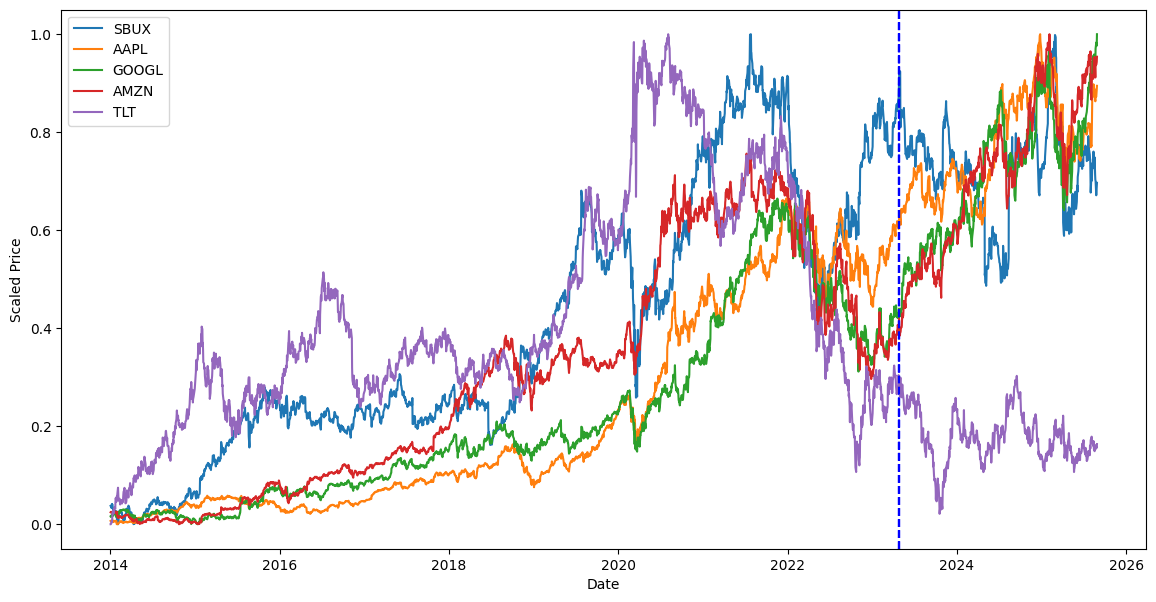

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


def fetch_stock_data(ticker, start, end, auto_adjust=True):
    # 경고 제거 및 일관성 확보
    df = yf.download(ticker, start=start, end=end, auto_adjust=auto_adjust, progress=False)
    # 혹시 MultiIndex 컬럼이면 평탄화
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    return df.dropna(subset=['Close'])

def _get_close_series(df: pd.DataFrame) -> pd.Series:
    """Close를 항상 1차원 Series로 안전하게 반환"""
    close = df['Close']
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    return pd.to_numeric(close, errors='coerce').dropna()

def calculate_volatility(data: pd.DataFrame) -> float:
    """수익률 표준편차(표본) = 변동성"""
    close = _get_close_series(data)
    rets = close.pct_change().dropna()
    return float(rets.std(ddof=1))

def calculate_statistics(data: pd.DataFrame) -> dict:
    close = _get_close_series(data)
    stats = {
        'Mean': float(close.mean()),
        'Median': float(close.median()),
        'Min': float(close.min()),
        'Max': float(close.max()),
        'Standard Deviation': float(close.std(ddof=1)),
        'Skewness': float(skew(close, bias=False)),
        'Kurtosis': float(kurtosis(close, fisher=True, bias=False)),
    }
    return stats


def analyze_stock_volatility_and_statistics(tickers, start, end):
    stock_volatilities = {}
    stock_statistics = {}

    for ticker in tickers:
        data = fetch_stock_data(ticker, start, end)
        if data.empty:
            print(f"Data not available for {ticker}")
            continue

        # 변동성 계산
        volatility = calculate_volatility(data)
        stock_volatilities[ticker] = volatility

        # 기술 통계 계산
        stats = calculate_statistics(data)
        stock_statistics[ticker] = stats

        print(f"{ticker} 변동성 (표준편차): {volatility:.4f}")
        print(f"{ticker} 기술통계: {stats}\n")

    # 변동성에 따른 종목 분석
    stock_df = pd.DataFrame(list(stock_volatilities.items()), columns=['Ticker', 'Volatility'])
    stock_df.sort_values(by='Volatility', ascending=False, inplace=True)

    print("\n변동성에 따른 종목 분석:")
    print(stock_df)

    # 기술통계를 DataFrame으로 변환
    stock_stats_df = pd.DataFrame(stock_statistics).T
    print("\n종목별 기술 통계:")
    print(stock_stats_df)

    return stock_df, stock_stats_df


def plot_scaled_closing_prices(tickers, start, end):
    plt.figure(figsize=(14, 7))
    scaler = MinMaxScaler(feature_range=(0, 1))

    for ticker in tickers:
        data = fetch_stock_data(ticker, start, end)
        if data.empty:
            print(f"Data not available for {ticker}")
            continue

        close_prices = data['Close'].values.reshape(-1, 1)
        scaled_prices = scaler.fit_transform(close_prices)
        train_size = int(len(scaled_prices) * 0.8)  # 80% train size for vertical line

        plt.plot(data.index, scaled_prices, label=ticker)
        plt.axvline(x=data.index[train_size], color='b', linestyle='--')

    plt.xlabel("Date")
    plt.ylabel("Scaled Price")
    plt.legend()
    plt.show()



# 종목 리스트
tickers = [ 'SBUX','AAPL', 'GOOGL', 'AMZN', 'TLT']
#tickers = ['AAPL', 'SBUX', 'TLT', '^TNX','USDKRW=X', 'GOOGL', 'TSLA', 'AMZN','^IXIC','^GSPC']


# 종목 변동성 및 기술 통계 분석
analyze_stock_volatility_and_statistics(tickers, startdate, enddate)

# 종가 데이터 플로팅
plot_scaled_closing_prices(tickers, startdate, enddate)

## GOOGL

In [15]:
# HemisphereModel 클래스 정의가 포함된 모듈을 임포트 또는 정의가 있다고 가정
# from your_module import HemisphereModel, ModelManager

# 데이터 다운로드 및 전처리 (사용자가 제공한 데이터 다운로드 방식)
ticker = 'GOOGL'
data = yf.download(ticker, start=startdate, end=enddate, auto_adjust=False, progress=False)

# Check if 'Adj Close' exists, otherwise use 'Close'
if 'Adj Close' in data.columns:
    data['Return'] = data['Adj Close'].pct_change().fillna(0)
else:
    data['Return'] = data['Close'].pct_change().fillna(0)

In [16]:
# ModelManager 클래스 인스턴스 생성
model_manager = ModelManager(
    ticker=ticker,
    start_date=startdate,
    end_date= enddate,
    single_model_types=single_model_types,
    combinations=combinations,
    depth_neuron_mapping=depth_neuron_mapping
)

# 데이터 다운로드 및 전처리 실행
model_manager.download_and_preprocess_data()

# HemisphereModel 클래스에 대한 정의가 필요함
# HemisphereModel 클래스는 사용자 정의 모델 빌딩 로직을 포함해야 함

# 모델 학습을 위한 데이터 전처리 실행
model_manager.preprocess_model_data(HemisphereModel)

# 데이터셋 정보 출력
model_manager.print_dataset_info()

Data downloaded and preprocessed.
Data preprocessed for model training.
Dataset Information
Total Dataset:   Period: 2014-01-02 00:00:00 to 2025-08-28 00:00:00, Count: 2932
Training Dataset: Period: 2014-01-13 00:00:00 to 2023-04-28 00:00:00, Count: 2340
Test Dataset:    Period: 2023-05-01 00:00:00 to 2025-08-28 00:00:00, Count: 585
기술통계1
Price    Adj Close       Close        High         Low        Open  \
Ticker       GOOGL       GOOGL       GOOGL       GOOGL       GOOGL   
count  2932.000000 2932.000000 2932.000000 2932.000000 2932.000000   
mean     82.849882   83.355634   84.220318   82.449790   83.321843   
std      48.918557   49.129084   49.685466   48.554914   49.096251   
min      24.682762   24.853001   25.014000   24.545500   24.962000   
25%      40.212650   40.490001   40.695125   40.247876   40.484251   
50%      61.850414   62.277000   62.870001   61.780001   62.255749   
75%     123.696354  124.549501  125.611624  122.802500  124.539997   
max     211.450882  211.63999

In [17]:
# --- PATCH: CBNN/DCBNN 빌더 교체 (연결성 보장 & 입력 shape=(L, F)) ---
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def patched_build_cross_brain_model(self, left_model, right_model):
    L, F = self.look_back, self.num_features
    left_input  = Input(shape=(L, F))
    right_input = Input(shape=(L, F))

    left_base  = left_model(left_input)     # 좌 경로 유지
    right_base = right_model(right_input)   # 우 경로 유지

    # 교차(CCC) + 원 경로 보존 → 두 입력 모두 최종 출력에 연결 보장
    cross_left  = Dense(64, activation='relu')(right_base)
    cross_right = Dense(64, activation='relu')(left_base)

    final = Concatenate()([left_base, cross_left, right_base, cross_right])
    out   = Dense(1)(final)

    m = Model(inputs=[left_input, right_input], outputs=out)
    m.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
    return m

def patched_build_deep_cross_brain_model_tune(self, left_model, right_model, depth=3, left_neurons=None, right_neurons=None):
    if left_neurons is None or right_neurons is None:
        raise ValueError("Please provide both left_neurons and right_neurons lists.")
    if len(left_neurons) != depth or len(right_neurons) != depth:
        raise ValueError("The length of left_neurons and right_neurons must match the depth.")

    L, F = self.look_back, self.num_features
    left_input  = Input(shape=(L, F))
    right_input = Input(shape=(L, F))

    left_base  = left_model(left_input)     # 원 경로
    right_base = right_model(right_input)

    left_out, right_out = left_base, right_base
    for d in range(depth):
        ln, rn = int(left_neurons[d]), int(right_neurons[d])
        # 양방향 결합 + 원/교차 모두 유지 → 항상 두 입력의 경로가 살아있음
        left_out  = Dense(ln, activation='relu')(Concatenate()([left_out, right_out]))
        right_out = Dense(rn, activation='relu')(Concatenate()([right_out, left_out]))

    final = Concatenate()([left_out, right_out, left_base, right_base])
    out   = Dense(1)(final)

    m = Model(inputs=[left_input, right_input], outputs=out)
    m.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
    return m



In [18]:
# 적용(몽키패치)
HemisphereModel.build_cross_brain_model = patched_build_cross_brain_model
HemisphereModel.build_deep_cross_brain_model_tune = patched_build_deep_cross_brain_model_tune


# CBNN/DCBNN 항목만 제거
model_manager.models = [m for m in model_manager.models
                        if not (m[0].startswith("CBNN") or m[0].startswith("DCBNN"))]

# 패치된 빌더로 다시 생성
model_manager.build_combined_models(HemisphereModel)          # CBNN
model_manager.build_deep_cross_brain_models(HemisphereModel)  # DCBNN

include_keywords = [
    "Single model LSTM",
    "Single model CNN",

    "CBNN CNN + CNN",
    "CBNN RNN + RNN",
    "CBNN LSTM + LSTM",
    "CBNN CNN + RNN",
    "CBNN CNN + LSTM",
    "CBNN RNN + CNN",
    "CBNN RNN + LSTM",
    "CBNN LSTM + CNN",
    "CBNN LSTM + RNN",

    "DCBNN CNN + CNN 3 layers",
    "DCBNN CNN + CNN 5 layers",
    "DCBNN CNN + CNN 7 layers",
    "DCBNN CNN + CNN 9 layers",
    "DCBNN RNN + RNN 3 layers",
    "DCBNN RNN + RNN 5 layers",
    "DCBNN RNN + RNN 7 layers",
    "DCBNN RNN + RNN 9 layers",
    "DCBNN LSTM + LSTM 3 layers",
    "DCBNN LSTM + LSTM 5 layers",
    "DCBNN LSTM + LSTM 7 layers",
    "DCBNN LSTM + LSTM 9 layers",
    "DCBNN CNN + RNN 3 layers",
    "DCBNN CNN + RNN 5 layers",
    "DCBNN CNN + RNN 7 layers",
    "DCBNN CNN + RNN 9 layers",
    "DCBNN CNN + LSTM 3 layers",
    "DCBNN CNN + LSTM 5 layers",
    "DCBNN CNN + LSTM 7 layers",
    "DCBNN CNN + LSTM 9 layers",
    "DCBNN RNN + CNN 3 layers",
    "DCBNN RNN + CNN 5 layers",
    "DCBNN RNN + CNN 7 layers",
    "DCBNN RNN + CNN 9 layers",
    "DCBNN RNN + LSTM 3 layers",
    "DCBNN RNN + LSTM 5 layers",
    "DCBNN RNN + LSTM 7 layers",
    "DCBNN RNN + LSTM 9 layers",
    "DCBNN LSTM + CNN 3 layers",
    "DCBNN LSTM + CNN 5 layers",
    "DCBNN LSTM + CNN 7 layers",
    "DCBNN LSTM + CNN 9 layers",
    "DCBNN LSTM + RNN 3 layers",
    "DCBNN LSTM + RNN 5 layers",
    "DCBNN LSTM + RNN 7 layers",
    "DCBNN LSTM + RNN 9 layers",
]

wf_summary, dm_table, pretty = run_walk_forward_subset(
    model_manager,
    HemisphereModel,
    include_keywords=include_keywords,
    n_folds=5,
    mode='expanding',
    epochs=50, batch_size=32, patience=8, verbose=0,
    ref_model=None,
    dm_alternative="two_sided"
)

display(pretty)
if dm_table is not None and not dm_table.empty:
    print("\nDM tests vs reference:")
    display(dm_table.assign(p_value=dm_table['p_value'].map(lambda x: f"{x:.4g}")))


# p-value → 기호
def p_to_symbol(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'

# DM 각주용 매핑 만들기 (ref는 dm_table['Model_B'][0])
ref = dm_table['Model_B'].iloc[0] if (dm_table is not None and not dm_table.empty) else None
pmap = {row['Model_A']: row['p_value'] for _, row in dm_table.iterrows()} if ref else {}

table = pretty.copy()
if ref:
    table['DM vs ' + ref] = table['Model'].map(lambda m: p_to_symbol(pmap[m]) if m in pmap else ('(ref)' if m==ref else '—'))

display(table)


import numpy as np
import pandas as pd

def p_format(p):
    return f"{p:.3f}" if p >= 0.001 else "<0.001"

def star(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'

def holm_bonferroni(pvals):
    m = len(pvals)
    order = np.argsort(pvals)
    adj = np.empty(m)
    running = 0.0
    for rank, i in enumerate(order, start=1):
        adj[i] = min(1.0, (m - rank + 1) * pvals[i])
    return adj

# dm_table: columns ['Model_A','Model_B','DM','p_value']
p = dm_table['p_value'].values.astype(float)
dm_table['p_adj'] = holm_bonferroni(p)
dm_table['p_value_fmt'] = [p_format(x) for x in dm_table['p_value']]
dm_table['p_adj_fmt']   = [p_format(x) for x in dm_table['p_adj']]
dm_table['sig']         = [star(x) for x in dm_table['p_adj']]
display(dm_table[['Model_A','Model_B','DM','p_value_fmt','p_adj_fmt','sig']])


[Model filter] kept 45/63

[Fold 1/5] Train: 2014-01-02 00:00:00 ~ 2015-12-08 00:00:00 Test: 2015-12-09 00:00:00 ~ 2017-11-14 00:00:00
  - CBNN CNN + CNN (is_dual_input=True)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 1.454151, MSE: 2.693583, RMSE: 1.641214, MAPE: 0.033681, SMAPE: 3.434613, NRMSE: 0.087032, RRMSE(%): 3.921872, R²: 0.882055, MASE: 2.728392
  - CBNN RNN + RNN (is_dual_input=True)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE: 4.308368, MSE: 27.440702, RMSE: 5.238387, MAPE: 0.096476, SMAPE: 10.327831, NRMSE: 0.277788, RRMSE(%): 12.517737, R²: -0.201554, MASE: 8.083698
  - CBNN LSTM + LSTM (is_dual_input=True)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
MAE: 2.942799, MSE: 15.811497, RMSE: 3.976367, MAPE: 0.064623, SMAPE: 6.823753, NRMSE: 0.210864, RRMSE(%): 9.501993, R²: 0.307658, MASE: 5.521512
  - CBNN CNN + RNN (is_dual_input=True)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
MAE: 2.704822, MSE: 12.139261, RMSE: 3.484144, MAPE: 0.059902, SMAPE: 6.273040, NRMSE: 0.184762, RRMSE(

,Model,MAE_mean,MAE_std,RMSE_mean,RMSE_std,SMAPE_mean,SMAPE_std,MASE_mean,MASE_std,MAPE_mean,MAPE_std,R2_mean,R2_std,NRMSE_mean,NRMSE_std,RRMSE_mean,RRMSE_std
0,DCBNN LSTM + CNN 3 layers,1.946481,0.866965,2.517453,1.142288,2.083638,0.465802,1.181014,0.427475,0.020761,0.004593,0.949953,0.028155,0.052650,0.013066,2.695687,0.582619
1,CBNN LSTM + CNN,2.082437,0.863545,2.638232,1.133233,2.240731,0.438080,1.288895,0.462256,0.022227,0.004187,0.939409,0.045598,0.056440,0.016345,2.871038,0.659311
2,DCBNN RNN + CNN 3 layers,2.087442,0.990709,2.629279,1.265928,2.200074,0.472860,1.231210,0.399082,0.021898,0.004715,0.947280,0.028158,0.054142,0.013068,2.764581,0.560947
3,DCBNN CNN + CNN 3 layers,2.245258,1.149683,2.819309,1.467634,2.350647,0.445564,1.339326,0.513590,0.023390,0.004329,0.937384,0.033576,0.058354,0.015428,2.939104,0.499882
4,DCBNN CNN + CNN 5 layers,2.286871,1.051696,2.859714,1.322767,2.445136,0.541651,1.402993,0.596278,0.024305,0.005258,0.931800,0.038227,0.060933,0.017401,3.060086,0.575010
5,DCBNN LSTM + CNN 7 layers,2.427647,1.329721,3.106440,1.704241,2.401041,0.562117,1.317602,0.283106,0.023971,0.005607,0.935805,0.032123,0.060027,0.012462,3.115434,0.728051
6,DCBNN RNN + CNN 7 layers,2.432150,1.480897,3.093051,1.847305,2.308831,0.813884,1.224168,0.302522,0.022929,0.007928,0.941242,0.033307,0.056826,0.015725,3.001620,1.021906
7,DCBNN RNN + CNN 5 layers,2.513107,1.976527,3.171688,2.438673,2.379218,1.332521,1.233400,0.492446,0.023421,0.012740,0.929110,0.061852,0.059266,0.030270,3.054470,1.696000
8,DCBNN CNN + CNN 7 layers,2.568174,1.338101,3.251704,1.731895,2.624718,0.535790,1.463827,0.379619,0.025987,0.005116,0.919173,0.044374,0.066392,0.018035,3.332389,0.645637
9,DCBNN LSTM + CNN 5 layers,2.753798,2.003047,3.392700,2.353222,2.546313,0.813679,1.377152,0.353603,0.025250,0.007950,0.928949,0.042815,0.061837,0.017362,3.203589,0.935274



== DM tests vs reference: DCBNN LSTM + CNN 3 layers ==


,Model_A,Model_B,DM,p_value
0,CBNN RNN + RNN,DCBNN LSTM + CNN 3 layers,9.214606,0.000000
1,CBNN CNN + RNN,DCBNN LSTM + CNN 3 layers,10.232314,0.000000
2,DCBNN RNN + RNN 7 layers,DCBNN LSTM + CNN 3 layers,9.870121,0.000000
3,DCBNN CNN + CNN 5 layers,DCBNN LSTM + CNN 3 layers,8.726037,0.000000
4,DCBNN RNN + RNN 3 layers,DCBNN LSTM + CNN 3 layers,8.524156,0.000000
5,DCBNN RNN + RNN 5 layers,DCBNN LSTM + CNN 3 layers,8.881668,0.000000
6,DCBNN LSTM + LSTM 7 layers,DCBNN LSTM + CNN 3 layers,8.690583,0.000000
7,DCBNN RNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,9.468056,0.000000
8,DCBNN CNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,8.829083,0.000000
9,DCBNN CNN + LSTM 9 layers,DCBNN LSTM + CNN 3 layers,9.793046,0.000000



== Walk-forward (mean±std) ==


,Model,MAE,RMSE,SMAPE,NRMSE,RRMSE,R2
0,DCBNN LSTM + CNN 3 layers,1.9465±0.8670,2.5175±1.1423,2.0836±0.4658,0.0526±0.0131,2.6957±0.5826,0.9500±0.0282
1,CBNN LSTM + CNN,2.0824±0.8635,2.6382±1.1332,2.2407±0.4381,0.0564±0.0163,2.8710±0.6593,0.9394±0.0456
2,DCBNN RNN + CNN 3 layers,2.0874±0.9907,2.6293±1.2659,2.2001±0.4729,0.0541±0.0131,2.7646±0.5609,0.9473±0.0282
3,DCBNN CNN + CNN 3 layers,2.2453±1.1497,2.8193±1.4676,2.3506±0.4456,0.0584±0.0154,2.9391±0.4999,0.9374±0.0336
4,DCBNN CNN + CNN 5 layers,2.2869±1.0517,2.8597±1.3228,2.4451±0.5417,0.0609±0.0174,3.0601±0.5750,0.9318±0.0382
5,DCBNN LSTM + CNN 7 layers,2.4276±1.3297,3.1064±1.7042,2.4010±0.5621,0.0600±0.0125,3.1154±0.7281,0.9358±0.0321
6,DCBNN RNN + CNN 7 layers,2.4322±1.4809,3.0931±1.8473,2.3088±0.8139,0.0568±0.0157,3.0016±1.0219,0.9412±0.0333
7,DCBNN RNN + CNN 5 layers,2.5131±1.9765,3.1717±2.4387,2.3792±1.3325,0.0593±0.0303,3.0545±1.6960,0.9291±0.0619
8,DCBNN CNN + CNN 7 layers,2.5682±1.3381,3.2517±1.7319,2.6247±0.5358,0.0664±0.0180,3.3324±0.6456,0.9192±0.0444
9,DCBNN LSTM + CNN 5 layers,2.7538±2.0030,3.3927±2.3532,2.5463±0.8137,0.0618±0.0174,3.2036±0.9353,0.9289±0.0428



== DM tests (absolute-error loss) ==


,Model_A,Model_B,DM,p_value
0,CBNN RNN + RNN,DCBNN LSTM + CNN 3 layers,9.214606,0
1,CBNN CNN + RNN,DCBNN LSTM + CNN 3 layers,10.232314,0
2,DCBNN RNN + RNN 7 layers,DCBNN LSTM + CNN 3 layers,9.870121,0
3,DCBNN CNN + CNN 5 layers,DCBNN LSTM + CNN 3 layers,8.726037,0
4,DCBNN RNN + RNN 3 layers,DCBNN LSTM + CNN 3 layers,8.524156,0
5,DCBNN RNN + RNN 5 layers,DCBNN LSTM + CNN 3 layers,8.881668,0
6,DCBNN LSTM + LSTM 7 layers,DCBNN LSTM + CNN 3 layers,8.690583,0
7,DCBNN RNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,9.468056,0
8,DCBNN CNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,8.829083,0
9,DCBNN CNN + LSTM 9 layers,DCBNN LSTM + CNN 3 layers,9.793046,0


,Model,MAE,RMSE,SMAPE,NRMSE,RRMSE,R2
0,DCBNN LSTM + CNN 3 layers,1.9465±0.8670,2.5175±1.1423,2.0836±0.4658,0.0526±0.0131,2.6957±0.5826,0.9500±0.0282
1,CBNN LSTM + CNN,2.0824±0.8635,2.6382±1.1332,2.2407±0.4381,0.0564±0.0163,2.8710±0.6593,0.9394±0.0456
2,DCBNN RNN + CNN 3 layers,2.0874±0.9907,2.6293±1.2659,2.2001±0.4729,0.0541±0.0131,2.7646±0.5609,0.9473±0.0282
3,DCBNN CNN + CNN 3 layers,2.2453±1.1497,2.8193±1.4676,2.3506±0.4456,0.0584±0.0154,2.9391±0.4999,0.9374±0.0336
4,DCBNN CNN + CNN 5 layers,2.2869±1.0517,2.8597±1.3228,2.4451±0.5417,0.0609±0.0174,3.0601±0.5750,0.9318±0.0382
5,DCBNN LSTM + CNN 7 layers,2.4276±1.3297,3.1064±1.7042,2.4010±0.5621,0.0600±0.0125,3.1154±0.7281,0.9358±0.0321
6,DCBNN RNN + CNN 7 layers,2.4322±1.4809,3.0931±1.8473,2.3088±0.8139,0.0568±0.0157,3.0016±1.0219,0.9412±0.0333
7,DCBNN RNN + CNN 5 layers,2.5131±1.9765,3.1717±2.4387,2.3792±1.3325,0.0593±0.0303,3.0545±1.6960,0.9291±0.0619
8,DCBNN CNN + CNN 7 layers,2.5682±1.3381,3.2517±1.7319,2.6247±0.5358,0.0664±0.0180,3.3324±0.6456,0.9192±0.0444
9,DCBNN LSTM + CNN 5 layers,2.7538±2.0030,3.3927±2.3532,2.5463±0.8137,0.0618±0.0174,3.2036±0.9353,0.9289±0.0428



DM tests vs reference:


,Model_A,Model_B,DM,p_value
0,CBNN RNN + RNN,DCBNN LSTM + CNN 3 layers,9.214606,0
1,CBNN CNN + RNN,DCBNN LSTM + CNN 3 layers,10.232314,0
2,DCBNN RNN + RNN 7 layers,DCBNN LSTM + CNN 3 layers,9.870121,0
3,DCBNN CNN + CNN 5 layers,DCBNN LSTM + CNN 3 layers,8.726037,0
4,DCBNN RNN + RNN 3 layers,DCBNN LSTM + CNN 3 layers,8.524156,0
5,DCBNN RNN + RNN 5 layers,DCBNN LSTM + CNN 3 layers,8.881668,0
6,DCBNN LSTM + LSTM 7 layers,DCBNN LSTM + CNN 3 layers,8.690583,0
7,DCBNN RNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,9.468056,0
8,DCBNN CNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,8.829083,0
9,DCBNN CNN + LSTM 9 layers,DCBNN LSTM + CNN 3 layers,9.793046,0


,Model,MAE,RMSE,SMAPE,NRMSE,RRMSE,R2,DM vs DCBNN LSTM + CNN 3 layers
0,DCBNN LSTM + CNN 3 layers,1.9465±0.8670,2.5175±1.1423,2.0836±0.4658,0.0526±0.0131,2.6957±0.5826,0.9500±0.0282,(ref)
1,CBNN LSTM + CNN,2.0824±0.8635,2.6382±1.1332,2.2407±0.4381,0.0564±0.0163,2.8710±0.6593,0.9394±0.0456,***
2,DCBNN RNN + CNN 3 layers,2.0874±0.9907,2.6293±1.2659,2.2001±0.4729,0.0541±0.0131,2.7646±0.5609,0.9473±0.0282,***
3,DCBNN CNN + CNN 3 layers,2.2453±1.1497,2.8193±1.4676,2.3506±0.4456,0.0584±0.0154,2.9391±0.4999,0.9374±0.0336,***
4,DCBNN CNN + CNN 5 layers,2.2869±1.0517,2.8597±1.3228,2.4451±0.5417,0.0609±0.0174,3.0601±0.5750,0.9318±0.0382,***
5,DCBNN LSTM + CNN 7 layers,2.4276±1.3297,3.1064±1.7042,2.4010±0.5621,0.0600±0.0125,3.1154±0.7281,0.9358±0.0321,***
6,DCBNN RNN + CNN 7 layers,2.4322±1.4809,3.0931±1.8473,2.3088±0.8139,0.0568±0.0157,3.0016±1.0219,0.9412±0.0333,***
7,DCBNN RNN + CNN 5 layers,2.5131±1.9765,3.1717±2.4387,2.3792±1.3325,0.0593±0.0303,3.0545±1.6960,0.9291±0.0619,***
8,DCBNN CNN + CNN 7 layers,2.5682±1.3381,3.2517±1.7319,2.6247±0.5358,0.0664±0.0180,3.3324±0.6456,0.9192±0.0444,***
9,DCBNN LSTM + CNN 5 layers,2.7538±2.0030,3.3927±2.3532,2.5463±0.8137,0.0618±0.0174,3.2036±0.9353,0.9289±0.0428,***


,Model_A,Model_B,DM,p_value_fmt,p_adj_fmt,sig
0,CBNN RNN + RNN,DCBNN LSTM + CNN 3 layers,9.214606,<0.001,<0.001,***
1,CBNN CNN + RNN,DCBNN LSTM + CNN 3 layers,10.232314,<0.001,<0.001,***
2,DCBNN RNN + RNN 7 layers,DCBNN LSTM + CNN 3 layers,9.870121,<0.001,<0.001,***
3,DCBNN CNN + CNN 5 layers,DCBNN LSTM + CNN 3 layers,8.726037,<0.001,<0.001,***
4,DCBNN RNN + RNN 3 layers,DCBNN LSTM + CNN 3 layers,8.524156,<0.001,<0.001,***
5,DCBNN RNN + RNN 5 layers,DCBNN LSTM + CNN 3 layers,8.881668,<0.001,<0.001,***
6,DCBNN LSTM + LSTM 7 layers,DCBNN LSTM + CNN 3 layers,8.690583,<0.001,<0.001,***
7,DCBNN RNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,9.468056,<0.001,<0.001,***
8,DCBNN CNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,8.829083,<0.001,<0.001,***
9,DCBNN CNN + LSTM 9 layers,DCBNN LSTM + CNN 3 layers,9.793046,<0.001,<0.001,***


In [19]:
eff = robust_benchmark(model_manager, L=7, F=6, batch_size=256, warmup=3, reps=10)
display(eff)

,Model,Params,Size_MB,Inference_ms,Inference_std,PerSample_ms,Throughput_sps
5,CBNN RNN + CNN,73253,0.293000,117.195000,1.979000,0.457791,2184.400000
0,CBNN CNN + CNN,86245,0.345000,94.059000,2.779000,0.367419,2721.690000
1,CBNN RNN + RNN,90981,0.364000,126.610000,2.663000,0.494572,2021.950000
3,CBNN CNN + RNN,103973,0.416000,113.929000,2.296000,0.445037,2247.000000
29,DCBNN RNN + CNN 3 layers,110629,0.443000,116.475000,1.604000,0.454982,2197.890000
9,DCBNN CNN + CNN 3 layers,123621,0.494000,92.934000,1.855000,0.363023,2754.650000
13,DCBNN RNN + RNN 3 layers,128357,0.513000,125.999000,2.391000,0.492182,2031.770000
21,DCBNN CNN + RNN 3 layers,141349,0.565000,116.540000,1.658000,0.455233,2196.680000
7,CBNN LSTM + CNN,162149,0.649000,98.362000,1.564000,0.384226,2602.640000
6,CBNN RNN + LSTM,179877,0.720000,115.690000,2.146000,0.451914,2212.810000


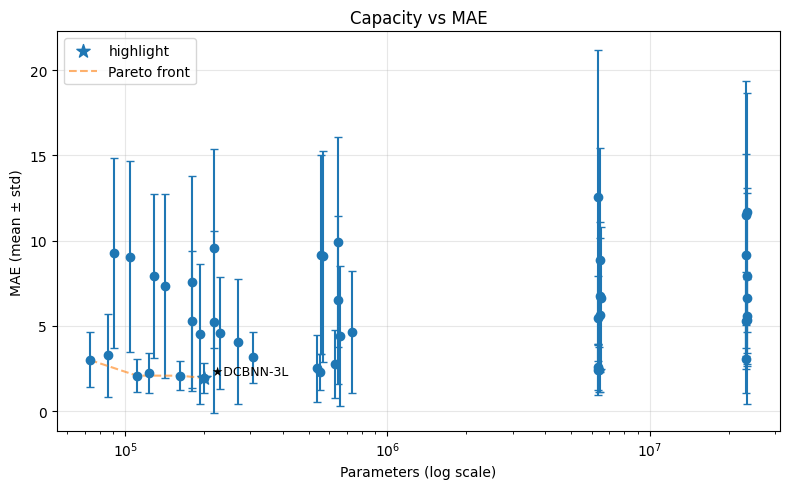

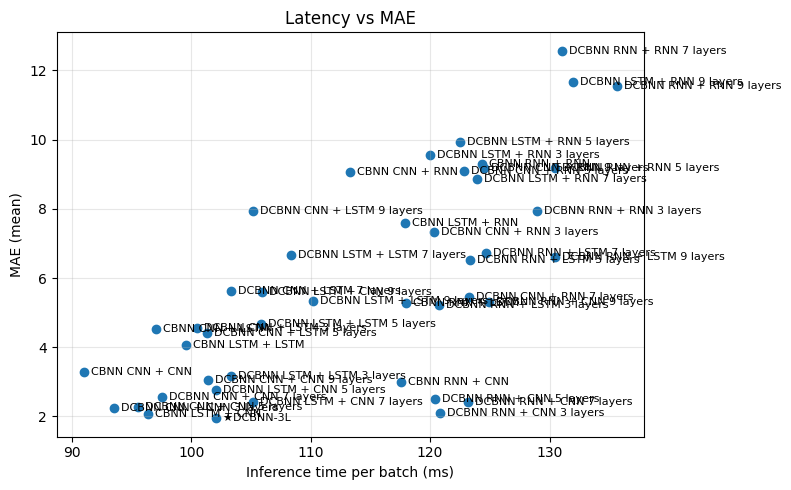

In [20]:
eff = robust_benchmark(model_manager, batch_size=256, warmup=3, reps=10)
plot_capacity_tradeoffs(wf_summary, eff, metric='MAE')
plot_latency_tradeoffs(wf_summary, eff, metric='MAE')

## SOTA

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd

# 기간 설정 (이미 변수 있으면 이 줄들은 생략 가능)
startdate = globals().get("startdate", "2014-01-02")
enddate   = globals().get("enddate",   "2025-08-29")


df = yf.download(ticker, start=startdate, end=enddate, auto_adjust=False, progress=False)
close = df["Close"].dropna().values.astype("float32")  # y: Close (당신의 기존 실험과 동일 타겟)

print(ticker, close.shape, df.index[0], "→", df.index[-1])


GOOGL (2932, 1) 2014-01-02 00:00:00 → 2025-08-28 00:00:00


In [22]:
# 실행 하이퍼파라미터
LOOK_BACK   = 60
HORIZON     = 1
N_FOLDS     = 5
MODE        = "expanding"  # 또는 "rolling"
SEASONALITY = 1

models_cfg = {
    "DLinear":  {"dropout": 0.0},
    "PatchTST": {"patch_len": 16, "stride": 8, "d_model": 128, "n_heads": 4,
                 "d_ff": 256, "n_layers": 2, "dropout": 0.1},
    # 새로 추가한 두 baseline
    "TFT":       {"d_model": 128, "lstm_hidden": 128, "n_heads": 4,
                  "n_layers": 1, "dropout": 0.1},
    "FEDformer": {"d_model": 128, "n_heads": 4, "d_ff": 256,
                  "n_layers": 2, "dropout": 0.1, "ma_kernel": 25}
}

# 실제 실행
res = evaluate_series_sota(
    y=close, look_back=LOOK_BACK, horizon=HORIZON,
    n_folds=N_FOLDS, mode=MODE,
    models_cfg=models_cfg, seasonality=SEASONALITY,
    epochs=20, lr=1e-3, batch_size=128
)

# ---- 요약 표 안전 평탄화 + mean±std 포맷 ----
def flatten_cols_safe(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        new_cols = []
        for tup in df.columns.to_flat_index():
            parts = [str(x) for x in tup if str(x) not in ("", None, "")]
            name = "_".join(parts) if parts else "col"
            while name.endswith("_"):
                name = name[:-1]
            new_cols.append(name)
        df = df.copy()
        df.columns = new_cols
    return df

def format_mean_std(df: pd.DataFrame, metrics=("MAE","RMSE","SMAPE","NRMSE","RRMSE","R2")) -> pd.DataFrame:
    df = flatten_cols_safe(df)
    # 모델 컬럼 자동 탐지
    model_col = None
    for c in df.columns:
        if str(c).lower().startswith("model"):
            model_col = c
            break
    if model_col is None:
        model_col = df.columns[0]
    out = pd.DataFrame({"Model": df[model_col]})
    for m in metrics:
        mc, sc = f"{m}_mean", f"{m}_std"
        if mc in df.columns and sc in df.columns:
            out[m] = [f"{mu:.4f}±{sd:.4f}" for mu, sd in zip(df[mc], df[sc])]
    return out

summary = res["summary"].copy()      # MultiIndex 컬럼
summary = flatten_cols_safe(summary) # 안전 평탄화
pretty  = format_mean_std(summary)   # mean±std 문자열화

from IPython.display import display
print("== SOTA (mean±std across folds) ==")
display(pretty)

print("\n== DM tests vs reference (", res["ref_model"], ") ==")
dm = res["dm"].copy()
dm["p_value_fmt"] = dm["p_value"].map(lambda p: f"{p:.4f}" if p>=0.001 else "<0.001")
display(dm[["Model_A","Model_B","DM","p_value_fmt"]])

print("\n== Capacity/Efficiency ==")
cap = res["capacity"].copy()
display(cap)


== SOTA (mean±std across folds) ==


,Model,MAE,RMSE,SMAPE,NRMSE,RRMSE,R2
0,DLinear,6.2856±4.2172,7.4850±5.0620,6.6351±3.0511,0.1644±0.0725,7.8775±3.7787,0.4401±0.3626
1,TFT,11.2257±6.8541,14.7095±9.6756,13.1706±7.4321,0.3018±0.0916,16.7519±10.0229,-0.6589±0.8749
2,PatchTST,15.7172±8.4886,19.1789±11.0021,18.2586±8.6488,0.3926±0.0827,21.0320±10.3003,-1.7734±1.2843
3,FEDformer,16.4226±10.8975,20.7543±14.5957,17.3753±11.0489,0.3632±0.0790,20.8079±13.6046,-1.3354±0.8876



== DM tests vs reference ( PatchTST ) ==


,Model_A,Model_B,DM,p_value_fmt
0,DLinear,PatchTST,-7.713497,<0.001
1,TFT,PatchTST,-15.682206,<0.001
2,FEDformer,PatchTST,1.887558,0.0591



== Capacity/Efficiency ==


,Model,Params,Inference_ms_per_step
0,DLinear,61,0.089000
1,TFT,248065,1.009000
2,FEDformer,281859,1.118000
3,PatchTST,283777,1.022000


In [23]:
res = evaluate_series_sota(
    y=close, look_back=30, horizon=1,
    n_folds=3, mode="expanding",
    models_cfg={"DLinear":{}, "PatchTST":{"d_model":64, "n_heads":2, "d_ff":128, "n_layers":1}},
    epochs=5, batch_size=64
)


In [24]:
res = evaluate_series_sota(
    y=close, look_back=30, horizon=1,
    n_folds=3, mode="expanding",
    # ✅ TFT와 FEDformer 설정을 여기에 추가합니다.
    models_cfg={
        "DLinear":  {},
        "PatchTST": {"d_model":64, "n_heads":2, "d_ff":128, "n_layers":1},
        "TFT":      {"d_model":64, "n_heads":2, "n_layers":1},
        "FEDformer":{"d_model":64, "n_heads":2, "n_layers":1}
    },
    epochs=5, batch_size=64
)

# DCBNN+SOTA

== Unified (CBNN/DCBNN + SOTA) mean±std ==


,Model,MAE,RMSE,SMAPE,NRMSE,RRMSE,R2
0,DCBNN LSTM + CNN 3 layers,1.9465±0.8670,2.5175±1.1423,2.0836±0.4658,0.0526±0.0131,2.6957±0.5826,0.9500±0.0282
1,CBNN LSTM + CNN,2.0824±0.8635,2.6382±1.1332,2.2407±0.4381,0.0564±0.0163,2.8710±0.6593,0.9394±0.0456
2,DCBNN RNN + CNN 3 layers,2.0874±0.9907,2.6293±1.2659,2.2001±0.4729,0.0541±0.0131,2.7646±0.5609,0.9473±0.0282
3,DCBNN CNN + CNN 3 layers,2.2453±1.1497,2.8193±1.4676,2.3506±0.4456,0.0584±0.0154,2.9391±0.4999,0.9374±0.0336
4,DCBNN CNN + CNN 5 layers,2.2869±1.0517,2.8597±1.3228,2.4451±0.5417,0.0609±0.0174,3.0601±0.5750,0.9318±0.0382
5,DCBNN LSTM + CNN 7 layers,2.4276±1.3297,3.1064±1.7042,2.4010±0.5621,0.0600±0.0125,3.1154±0.7281,0.9358±0.0321
6,DCBNN RNN + CNN 7 layers,2.4322±1.4809,3.0931±1.8473,2.3088±0.8139,0.0568±0.0157,3.0016±1.0219,0.9412±0.0333
7,DCBNN RNN + CNN 5 layers,2.5131±1.9765,3.1717±2.4387,2.3792±1.3325,0.0593±0.0303,3.0545±1.6960,0.9291±0.0619
8,DCBNN CNN + CNN 7 layers,2.5682±1.3381,3.2517±1.7319,2.6247±0.5358,0.0664±0.0180,3.3324±0.6456,0.9192±0.0444
9,DCBNN LSTM + CNN 5 layers,2.7538±2.0030,3.3927±2.3532,2.5463±0.8137,0.0618±0.0174,3.2036±0.9353,0.9289±0.0428


[INFO] DM reference model = DCBNN LSTM + CNN 3 layers  (ALT='greater', metric='RMSE_mean', scope='.*', dir='min')

== DM tests vs reference (DCBNN LSTM + CNN 3 layers) [greater] ==


,Model_A,Model_B,DM,p_value_fmt
0,DCBNN RNN + CNN 5 layers,DCBNN LSTM + CNN 3 layers,3.530068,0.9998
1,CBNN LSTM + CNN,DCBNN LSTM + CNN 3 layers,3.759421,0.9999
2,CBNN LSTM + LSTM,DCBNN LSTM + CNN 3 layers,4.900077,1.0000
3,CBNN RNN + CNN,DCBNN LSTM + CNN 3 layers,5.093329,1.0000
4,DCBNN RNN + LSTM 3 layers,DCBNN LSTM + CNN 3 layers,5.116738,1.0000
5,DCBNN CNN + LSTM 5 layers,DCBNN LSTM + CNN 3 layers,5.283525,1.0000
6,DCBNN RNN + CNN 3 layers,DCBNN LSTM + CNN 3 layers,5.308509,1.0000
7,CBNN CNN + LSTM,DCBNN LSTM + CNN 3 layers,5.342289,1.0000
8,DCBNN CNN + CNN 3 layers,DCBNN LSTM + CNN 3 layers,5.516945,1.0000
9,DCBNN LSTM + CNN 5 layers,DCBNN LSTM + CNN 3 layers,6.026748,1.0000


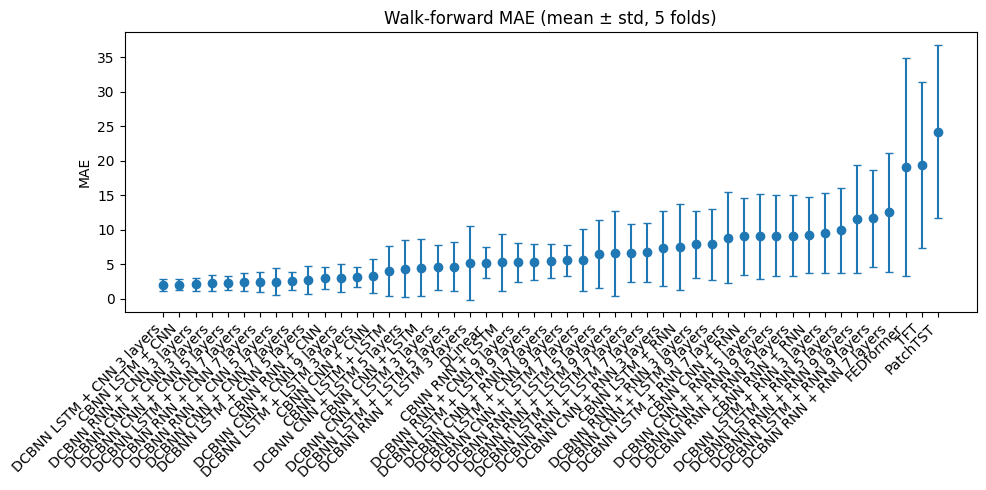


(참고) capacity 표를 합치려면 model_manager.capacity_table 과 res['capacity']가 있어야 합니다.


In [25]:
# ===== 1) 준비: 이미 계산된 결과를 변수로 넘겨주세요 =====
# CBNN/DCBNN 쪽:
#  - wf_cbnn: model_manager.walk_forward_summary  (컬럼: 'Model','MAE_mean','MAE_std','RMSE_mean',...,'R2_std', ...)
#  - err_cbnn: model_manager.errors_per_model     (fold별 절대오차 벡터 리스트를 concat하여 사용)
# SOTA 쪽:
#  - res = evaluate_series_sota(...) 반환 딕트
#    res["summary"] (MultiIndex cols), res["dm"], res["capacity"], res["fold_metrics"]
#  - err_sota = res 내부에서 만든 agg_errors 딕트(코드에 들어있음)  => 아래에서 재계산 가능

import re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ===== 설정: 참조모델 선택 규칙 & DM 대립가설 =====
PICK_METRIC = 'RMSE_mean'   # 'RMSE_mean' | 'MAE_mean' | 'R2_mean' 등
SCOPE_REGEX = r'.*'         # 전체에서 고르면 r'.*' , DCBNN만이면 r'^DCBNN '
DIRECTION   = 'min'         # RMSE/MAE는 'min', R2/Accuracy면 'max'

# DM: "ref보다 A가 나쁘다" 1-측 검정이면 'greater', 양측이면 'two_sided'
ALT         = 'greater'     # <- 필요시 'two_sided'로 변경

# --- 유틸: 모델명 정규화(공백/대소문자/중복 공백 정리) ---
def _norm_name(s: str) -> str:
    return re.sub(r'\s+', ' ', str(s)).strip()

# --- 2) SOTA summary 평탄화 & 컬럼명 맞추기 ---
def flatten_cols_safe(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = ["_".join([str(c) for c in tup if str(c)]) for tup in df.columns.to_flat_index()]
        df.columns = [c.rstrip("_") for c in df.columns]
    return df

def normalize_summary_cols(df: pd.DataFrame) -> pd.DataFrame:
    # df에는 최소 'Model'과 '<METRIC>_mean','<METRIC>_std'가 있어야 함
    keep = ['Model','MAE_mean','MAE_std','RMSE_mean','RMSE_std',
            'SMAPE_mean','SMAPE_std','NRMSE_mean','NRMSE_std',
            'RRMSE_mean','RRMSE_std','R2_mean','R2_std']
    out = df.copy()
    for k in keep:
        if k not in out.columns:
            out[k] = np.nan
    out['Model'] = out['Model'].map(_norm_name)
    return out[keep].copy()

# SOTA summary 정리
sota_sum = flatten_cols_safe(res['summary'].copy())
# 'Model' 컬럼 자동 탐지 → 'Model'로 통일
model_col = None
for c in sota_sum.columns:
    if str(c).lower().startswith('model'):
        model_col = c; break
if model_col != 'Model':
    sota_sum = sota_sum.rename(columns={model_col:'Model'})
sota_sum_n = normalize_summary_cols(sota_sum)

# CBNN/DCBNN summary 정리(이미 표준 컬럼명일 가능성 큼)
cbnn_sum_raw = model_manager.walk_forward_summary.copy()
if 'Model' not in cbnn_sum_raw.columns:
    # 혹시 다른 이름이면 자동 감지
    mc = [c for c in cbnn_sum_raw.columns if str(c).lower().startswith('model')]
    if mc: cbnn_sum_raw = cbnn_sum_raw.rename(columns={mc[0]:'Model'})
cbnn_sum_n = normalize_summary_cols(cbnn_sum_raw)

# --- 3) 병합 & 정렬 ---
combined = pd.concat([cbnn_sum_n, sota_sum_n], ignore_index=True)
combined['Model'] = combined['Model'].map(_norm_name)
combined = combined.sort_values('MAE_mean', ascending=True).reset_index(drop=True)

# 보기좋게 mean±std 문자열 버전
def format_mean_std(df, metrics=('MAE','RMSE','SMAPE','NRMSE','RRMSE','R2')):
    out = df[['Model']].copy()
    for m in metrics:
        mu_col, sd_col = f'{m}_mean', f'{m}_std'
        out[m] = df.apply(lambda r: f"{r[mu_col]:.4f}±{r[sd_col]:.4f}", axis=1)
    return out

pretty_all = format_mean_std(combined)
print("== Unified (CBNN/DCBNN + SOTA) mean±std ==")
display(pretty_all)

# --- 3-1) 참조모델 자동 선택 ---
def pick_best_model_name(summary_df: pd.DataFrame,
                         metric: str = PICK_METRIC,
                         scope_regex: str = SCOPE_REGEX,
                         direction: str = DIRECTION) -> str | None:
    if summary_df is None or summary_df.empty:
        return None
    df = summary_df.copy()
    df = df[df['Model'].astype(str).str.contains(scope_regex, regex=True)]
    if df.empty or metric not in df.columns:
        return None
    df = df.dropna(subset=[metric])
    if df.empty:
        return None
    idx = df[metric].idxmin() if direction == 'min' else df[metric].idxmax()
    return str(df.loc[idx, 'Model'])

ref_name = pick_best_model_name(combined, metric=PICK_METRIC, scope_regex=SCOPE_REGEX, direction=DIRECTION)
if ref_name is None:
    ref_name = 'DCBNN LSTM + CNN 3 layers'  # 안전장치(fallback)
ref_name = _norm_name(ref_name)
print(f"[INFO] DM reference model = {ref_name}  (ALT='{ALT}', metric='{PICK_METRIC}', scope='{SCOPE_REGEX}', dir='{DIRECTION}')")

# ===== 4) DM test: 기준(ref) vs SOTA/CBNN 전부 쌍대 비교 =====
# CBNN 측 절대오차 벡터 꺼내기
def concat_errors(error_chunks_list):
    if not error_chunks_list:
        return np.array([])
    return np.concatenate(error_chunks_list)

# CBNN errors_per_model 는 walk_forward_evaluate 안에서 만든 딕트
err_cbnn_all = { _norm_name(name): concat_errors(chunks)
                 for name, chunks in getattr(model_manager, 'errors_per_model', {}).items() }

# SOTA errors는 evaluate_series_sota 내부 agg_errors (fold마다 추가한 절대오차 벡터)
agg_errors_sota_raw = res.get('agg_errors', {})
agg_errors_sota = { _norm_name(k): v for k, v in agg_errors_sota_raw.items() }

# DM helper (이미 구현된 dm_test 재사용)
def dm_against_ref(errors_ref, errors_other, alternative='two_sided'):
    a = np.asarray(errors_other).reshape(-1)
    b = np.asarray(errors_ref).reshape(-1)
    n = min(len(a), len(b))
    if n == 0:
        return np.nan, np.nan
    a, b = a[:n], b[:n]
    # 관례: DM은 mean(loss_A - loss_ref) 기반 → 'greater'면 A가 ref보다 나쁜지 테스트
    return dm_test(a, b, alternative=alternative)

ref_err = err_cbnn_all.get(ref_name, None)
dm_rows = []
if ref_err is not None and len(ref_err) > 0:
    # SOTA와 CBNN(기타) 모두 상대 비교
    candidates = list(agg_errors_sota.keys()) + [m for m in err_cbnn_all.keys() if _norm_name(m) != ref_name]
    seen = set()
    for name in candidates:
        name_n = _norm_name(name)
        if name_n in seen:
            continue
        seen.add(name_n)
        # SOTA
        if name_n in agg_errors_sota:
            dm, p = dm_against_ref(ref_err, agg_errors_sota[name_n], alternative=ALT)
            dm_rows.append(dict(Model_A=name_n, Model_B=ref_name, DM=dm, p_value=p))
        # CBNN/기타
        elif name_n in err_cbnn_all:
            dm, p = dm_against_ref(ref_err, err_cbnn_all[name_n], alternative=ALT)
            dm_rows.append(dict(Model_A=name_n, Model_B=ref_name, DM=dm, p_value=p))
else:
    print("[WARN] Reference error array is empty or missing; DM table will be empty.")

dm_vs_ref = pd.DataFrame(dm_rows)
if not dm_vs_ref.empty:
    dm_vs_ref = dm_vs_ref.sort_values('p_value').reset_index(drop=True)
    dm_vs_ref['p_value_fmt'] = dm_vs_ref['p_value'].map(lambda x: f"{x:.4f}" if pd.notnull(x) and x>=0.001 else "<0.001")
    print(f"\n== DM tests vs reference ({ref_name}) [{ALT}] ==")
    display(dm_vs_ref[['Model_A','Model_B','DM','p_value_fmt']])
else:
    print("\n(No DM table — check that both CBNN and SOTA error arrays are available.)")

# ===== 5) 그림 두 장(논문용) =====
# (a) MAE mean±std 에러바
plt.figure(figsize=(10,5))
x = np.arange(len(combined))
plt.errorbar(x, combined['MAE_mean'], yerr=combined['MAE_std'], fmt='o', capsize=3)
plt.xticks(x, combined['Model'], rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('Walk-forward MAE (mean ± std, 5 folds)')
plt.tight_layout()
plt.show()

# (b) 성능-복잡도 스캐터(Params vs MAE_mean)
# capacity 표 합치기: CBNN/DCBNN의 파라미터/추론시간 표 + SOTA의 capacity
cap_cbnn = pd.DataFrame(getattr(model_manager, 'capacity_table', [])) if hasattr(model_manager, 'capacity_table') else None
cap_sota = res['capacity'].copy() if 'capacity' in res else None

cap_combined = None
if cap_cbnn is not None and not cap_cbnn.empty and cap_sota is not None and not cap_sota.empty:
    cap_combined = pd.concat([
        cap_cbnn.rename(columns={'Inference_ms':'Inference_ms_per_step'})[['Model','Params','Inference_ms_per_step']],
        cap_sota[['Model','Params','Inference_ms_per_step']]
    ], ignore_index=True)
    cap_combined['Model'] = cap_combined['Model'].map(_norm_name)

    # MAE_mean 매핑
    mae_map = dict(zip(combined['Model'], combined['MAE_mean']))
    cap_combined['MAE_mean'] = cap_combined['Model'].map(mae_map)

    plt.figure(figsize=(7,5))
    plt.scatter(cap_combined['Params'], cap_combined['MAE_mean'])
    for _, r in cap_combined.iterrows():
        plt.annotate(r['Model'], (r['Params'], r['MAE_mean']), xytext=(5,3), textcoords='offset points', fontsize=8)
    plt.xlabel('Parameters')
    plt.ylabel('MAE (mean over folds)')
    plt.title('Performance vs Model Size')
    plt.tight_layout()
    plt.show()
else:
    print("\n(참고) capacity 표를 합치려면 model_manager.capacity_table 과 res['capacity']가 있어야 합니다.")


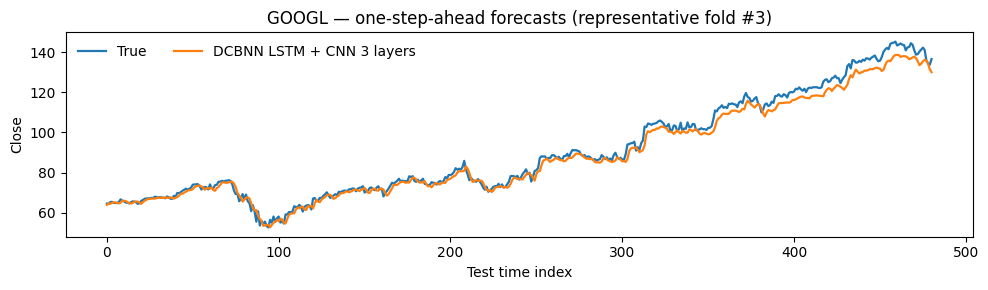

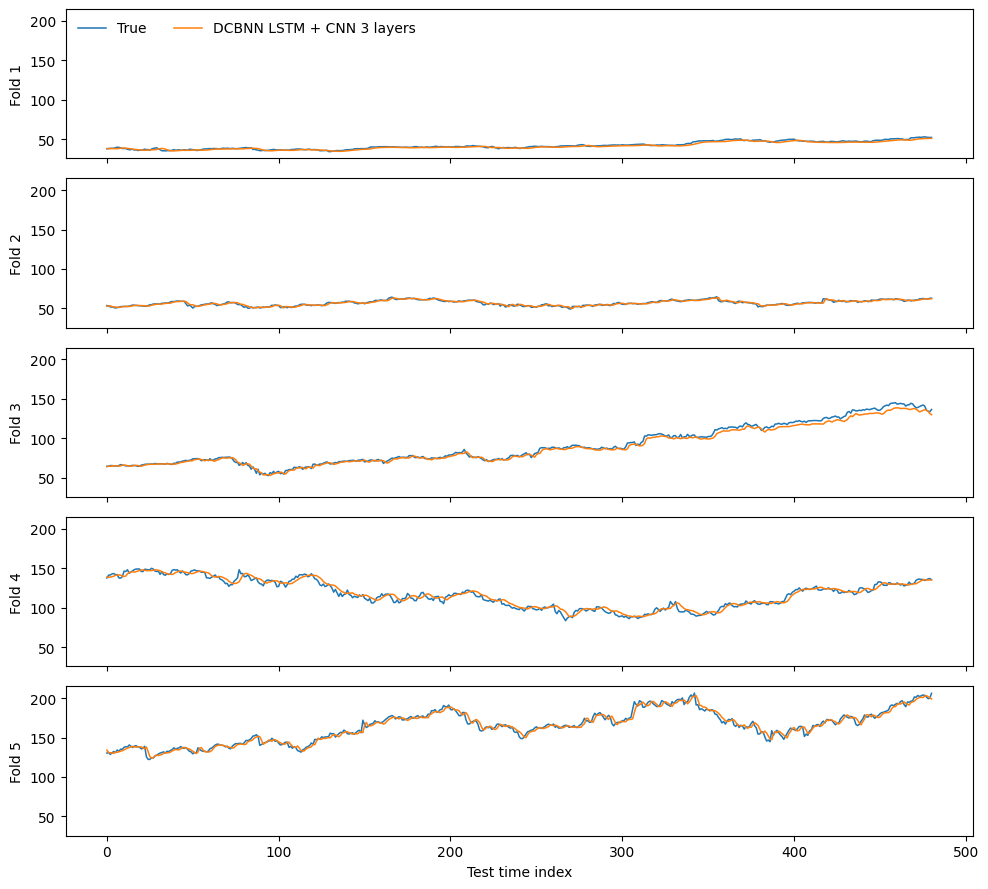

In [26]:
# ===== 6) WF 라인플롯: 대표 예측 곡선(Fig.5) + 폴드별 OOS(부록) =====
# 저장 대신 화면 표시(plt.show())만 수행

import numpy as np
import matplotlib.pyplot as plt

# -------- 공통 유틸 --------
def _to_1d_close(arr):
    """(N,H,C) or (N,H) or (N,) -> (N,)  (H,C 평균 후 평탄화, H=1 가정이면 그대로)"""
    a = np.asarray(arr)
    if a.ndim == 3:  # (N,H,C)
        return a.mean(axis=2).reshape(-1)
    if a.ndim == 2:  # (N,H)
        return a.reshape(-1)
    return a  # (N,)

def _pick_median_fold(y_true_list, y_pred_list):
    maes = [np.mean(np.abs(_to_1d_close(yt) - _to_1d_close(yp)))
            for yt, yp in zip(y_true_list, y_pred_list)]
    k = int(np.argsort(maes)[len(maes)//2])
    return k, maes

def _ensure_lists(x):
    return list(x) if isinstance(x, (list, tuple)) else [x]

# -------- CBNN/DCBNN 쪽: 폴드별 예측/정답 자동 탐지 --------
def find_cbnn_series(model_manager, model_name):
    true_keys = ['fold_y_true','trues_concat','fold_trues','true_per_fold']
    pred_keys = ['fold_y_pred','preds_concat','fold_preds_per_model','predictions_per_fold','preds_per_model']
    y_trues = None
    y_preds = None

    for tk in true_keys:
        if hasattr(model_manager, tk):
            y_trues = getattr(model_manager, tk)
            break
    for pk in pred_keys:
        if hasattr(model_manager, pk):
            preds_store = getattr(model_manager, pk)
            if isinstance(preds_store, dict) and model_name in preds_store:
                y_preds = preds_store[model_name]
            elif isinstance(preds_store, (list, tuple)):
                y_preds = preds_store
            break

    return y_trues, y_preds

# -------- SOTA 쪽: 폴드별 예측/정답 --------
def find_sota_series(res, model_name):
    y_trues = res.get('trues', None)
    preds_dict = res.get('preds', None)
    if (y_trues is None) or (preds_dict is None) or (model_name not in preds_dict):
        return None, None
    return y_trues, preds_dict[model_name]

# -------- 그림: 대표 예측 곡선(본문) --------
def plot_representative_fold(y_trues, preds_dict, model_main, baselines, title):
    """y_trues: List[ndarray], preds_dict: {model->List[ndarray]}"""
    assert model_main in preds_dict, f"{model_main} not found in preds_dict."
    k, _ = _pick_median_fold(y_trues, preds_dict[model_main])
    yt = _to_1d_close(y_trues[k])

    plt.figure(figsize=(10,3))
    plt.plot(yt, label="True", lw=1.6)
    plt.plot(_to_1d_close(preds_dict[model_main][k]), label=model_main, lw=1.6)
    for b in _ensure_lists(baselines):
        if b in preds_dict:
            plt.plot(_to_1d_close(preds_dict[b][k]), label=b, alpha=0.95)
    plt.xlabel("Test time index"); plt.ylabel("Close")
    plt.title(title + f" (representative fold #{k+1})")
    plt.legend(ncol=min(4,2+len(_ensure_lists(baselines))), frameon=False)
    plt.tight_layout()
    plt.show()

# -------- 그림: 폴드별 OOS 라인(부록) --------
def plot_oos_subplots(y_trues, y_preds, model_name, ticker, sharey=True):
    K = len(y_trues)
    fig, axes = plt.subplots(K, 1, figsize=(10, 1.8*K), sharex=True, sharey=sharey)
    if K == 1: axes = [axes]
    for i in range(K):
        yt = _to_1d_close(y_trues[i])
        yp = _to_1d_close(y_preds[i])
        ax = axes[i]
        ax.plot(yt, label="True", lw=1.1)
        ax.plot(yp, label=model_name, lw=1.1)
        ax.set_ylabel(f"Fold {i+1}")
        if i == 0: ax.legend(ncol=2, frameon=False, loc="upper left")
    axes[-1].set_xlabel("Test time index")
    plt.tight_layout()
    plt.show()

# =========================================================
# ===== 6-1) GOOGL: 대표 예측 곡선 (DCBNN-3L vs CNN/LSTM) =====
# =========================================================
main_name   = "DCBNN LSTM + CNN 3 layers"
baseline_cn = "Single model CNN"
baseline_ls = "Single model LSTM"

cbnn_trues, cbnn_main_preds = find_cbnn_series(model_manager, main_name)
_,          cbnn_cnn_preds  = find_cbnn_series(model_manager, baseline_cn)
_,          cbnn_lstm_preds = find_cbnn_series(model_manager, baseline_ls)

cbnn_preds_dict = {}
if cbnn_main_preds is not None: cbnn_preds_dict[main_name]   = cbnn_main_preds
if cbnn_cnn_preds  is not None: cbnn_preds_dict[baseline_cn] = cbnn_cnn_preds
if cbnn_lstm_preds is not None: cbnn_preds_dict[baseline_ls] = cbnn_lstm_preds

if (cbnn_trues is not None) and (len(cbnn_trues)>0) and (main_name in cbnn_preds_dict):
    plot_representative_fold(
        y_trues=cbnn_trues, preds_dict=cbnn_preds_dict,
        model_main=main_name, baselines=[baseline_cn, baseline_ls],
        title="GOOGL — one-step-ahead forecasts"
    )
else:
    print("[Skip Fig.5] CBNN/DCBNN 폴드 예측/정답을 찾지 못했습니다. "
          "walk-forward 루프에서 fold별 y_true/y_pred를 저장해 주세요.")

# =========================================================
# ===== 6-2) GOOGL: DCBNN-3L 폴드별 OOS 라인(부록) =====
# =========================================================
if (cbnn_trues is not None) and (len(cbnn_trues)>0) and (main_name in cbnn_preds_dict):
    plot_oos_subplots(
        y_trues=cbnn_trues, y_preds=cbnn_preds_dict[main_name],
        model_name=main_name, ticker="GOOGL"
    )
else:
    print("[Skip OOS] GOOGL DCBNN-3L의 폴드 예측/정답이 없어 OOS 플롯을 생략합니다.")

# =========================================================
# ===== (선택) SOTA 예: DLinear OOS 라인 =====
# =========================================================
dl_trues, dl_preds = find_sota_series(res, "DLinear")
if (dl_trues is not None) and (dl_preds is not None) and (len(dl_trues)>0) and (len(dl_preds)>0):
    plot_oos_subplots(
        y_trues=dl_trues, y_preds=dl_preds,
        model_name="DLinear", ticker="GOOGL"
    )


[WARN] No candidate found for best model; fallback to manual name.
[INFO] Selected best model by RMSE: DCBNN LSTM + CNN 3 layers
[INFO] Baselines found: []


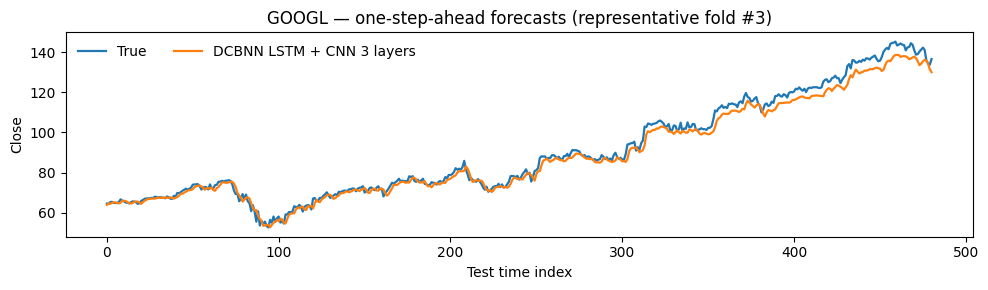

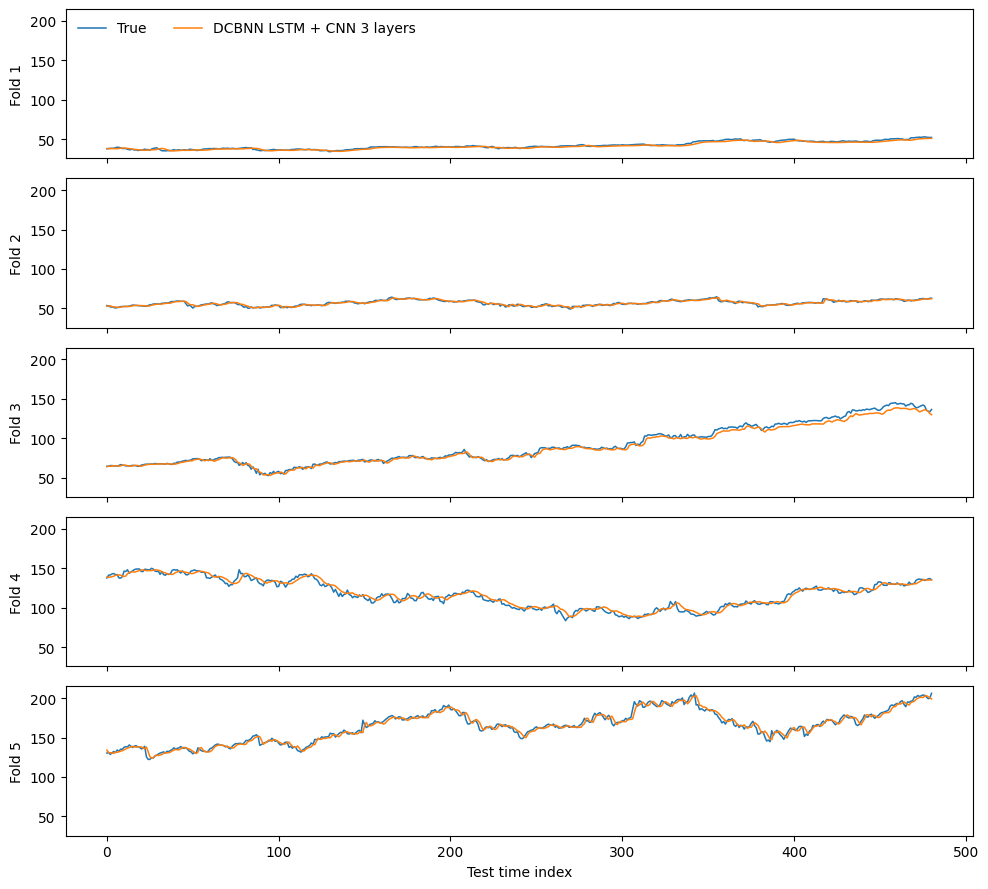

In [27]:
# ===== Pick the best model from WFCV summary and set main_name =====
import re
import numpy as np
import pandas as pd

# 1) 어떤 지표로 최적을 고를지 선택 (필요시 바꾸세요)
PICK_METRIC = "RMSE"           # 예: "RMSE" | "MAE" | "R²" | "MAPE" ...
SCOPE_REGEX = r"^DCBNN "       # 예: DCBNN만 후보로 (전체에서 고르려면 r".*" 로)

# 2) 지표 방향(최소/최대) 자동 판정
_MAX_METRICS = {"R²", "Accuracy"}
_MIN_METRICS = {"MAE","RMSE","MSE","MAPE","SMAPE","MASE","OWA","NRMSE","RRMSE"}

def _metric_direction(metric):
    m = metric.strip().upper().replace(" ", "")
    if m in {x.upper() for x in _MAX_METRICS}: return "max"
    return "min"

def _coerce_num(s):
    try:
        return pd.to_numeric(s, errors="coerce")
    except Exception:
        return pd.Series([np.nan]*len(s), index=s.index)

def pick_best_model_name(df, metric=PICK_METRIC, scope_regex=SCOPE_REGEX):
    if df is None or df.empty:
        return None
    d = df.copy()
    # 후보군 제한 (예: DCBNN만)
    if scope_regex:
        d = d[d["Model"].astype(str).str.contains(scope_regex, regex=True)]
    if d.empty:
        return None
    # 지표 숫자화
    if metric not in d.columns:
        # 예: 열 이름이 소문자/다른 포맷인 경우 대비
        cand = [c for c in d.columns if c.strip().lower() == metric.strip().lower()]
        if cand:
            metric = cand[0]
        else:
            raise KeyError(f"Metric column '{metric}' not found in summary table.")
    d[metric] = _coerce_num(d[metric])
    d = d.dropna(subset=[metric])
    if d.empty:
        return None

    direction = _metric_direction(metric)
    idx = d[metric].idxmax() if direction == "max" else d[metric].idxmin()
    return str(d.loc[idx, "Model"])

# ---- 실행: pretty(=WFCV 요약표)에서 최적 모델명 선택
auto_main = pick_best_model_name(pretty, metric=PICK_METRIC, scope_regex=SCOPE_REGEX)
if auto_main is None:
    print("[WARN] No candidate found for best model; fallback to manual name.")
    auto_main = "DCBNN LSTM + CNN 3 layers"   # 필요시 임시 기본값

# 베이스라인 후보 자동 구성: 등록되어 있고 예측이 존재하는 싱글모델만 사용
baseline_candidates = ["Single model CNN", "Single model LSTM", "Single model RNN"]
baselines = []
for b in baseline_candidates:
    _, preds = find_cbnn_series(model_manager, b)
    if preds is not None and len(preds) > 0:
        baselines.append(b)

# 최종 세팅(아래 6-1, 6-2 코드가 이 변수를 사용)
main_name   = auto_main
baseline_cn = "Single model CNN"   # 기존 변수와 호환을 위해 남겨두지만,
baseline_ls = "Single model LSTM"  # 실제 플롯은 baselines 리스트를 사용하도록 살짝 수정 권장

print(f"[INFO] Selected best model by {PICK_METRIC}: {main_name}")
print(f"[INFO] Baselines found: {baselines}")


cbnn_trues, cbnn_main_preds = find_cbnn_series(model_manager, main_name)
_,          cbnn_cnn_preds  = find_cbnn_series(model_manager, baseline_cn)
_,          cbnn_lstm_preds = find_cbnn_series(model_manager, baseline_ls)

cbnn_preds_dict = {}
if cbnn_main_preds is not None: cbnn_preds_dict[main_name]   = cbnn_main_preds
if cbnn_cnn_preds  is not None: cbnn_preds_dict[baseline_cn] = cbnn_cnn_preds
if cbnn_lstm_preds is not None: cbnn_preds_dict[baseline_ls] = cbnn_lstm_preds

if (cbnn_trues is not None) and (len(cbnn_trues)>0) and (main_name in cbnn_preds_dict):
    plot_representative_fold(
        y_trues=cbnn_trues, preds_dict=cbnn_preds_dict,
        model_main=main_name, baselines=[baseline_cn, baseline_ls],
        title="GOOGL — one-step-ahead forecasts"
    )
else:
    print("[Skip Fig.5] CBNN/DCBNN 폴드 예측/정답을 찾지 못했습니다. "
          "walk-forward 루프에서 fold별 y_true/y_pred를 저장해 주세요.")

# =========================================================
# ===== 6-2) GOOGL: DCBNN-3L 폴드별 OOS 라인(부록) =====
# =========================================================
if (cbnn_trues is not None) and (len(cbnn_trues)>0) and (main_name in cbnn_preds_dict):
    plot_oos_subplots(
        y_trues=cbnn_trues, y_preds=cbnn_preds_dict[main_name],
        model_name=main_name, ticker="GOOGL"
    )
else:
    print("[Skip OOS] GOOGL DCBNN-3L의 폴드 예측/정답이 없어 OOS 플롯을 생략합니다.")

# =========================================================
# ===== (선택) SOTA 예: DLinear OOS 라인 =====
# =========================================================
dl_trues, dl_preds = find_sota_series(res, "DLinear")
if (dl_trues is not None) and (dl_preds is not None) and (len(dl_trues)>0) and (len(dl_preds)>0):
    plot_oos_subplots(
        y_trues=dl_trues, y_preds=dl_preds,
        model_name="DLinear", ticker="GOOGL"
    )


In [28]:
from IPython.display import display

def format_mean_std(df, metrics=('MAE','RMSE','SMAPE','NRMSE','RRMSE','R2')):
    out = df[['Model']].copy()
    for m in metrics:
        out[m] = df.apply(lambda r: f"{r[f'{m}_mean']:.4f}±{r[f'{m}_std']:.4f}", axis=1)
    return out

def run_walk_forward_subset(
    model_manager,
    HemisphereModel,
    include_keywords=None,
    n_folds=5,
    mode='expanding',
    train_window=None,
    epochs=50,
    batch_size=32,
    patience=8,
    verbose=0,
    ref_model=None,
    dm_alternative="two_sided",
    metrics=('MAE','RMSE','SMAPE','NRMSE','RRMSE','R2'),
    show=True
):
    """
    - include_keywords: 포함할 모델명 키워드 리스트. None이면 필터링 없이 전체 실행.
    - dm_alternative: 'two_sided' | 'less' | 'greater'
    """
    # 1) 모델 필터 (선택)
    if include_keywords:
        before = len(model_manager.models)
        model_manager.models = [m for m in model_manager.models if any(kw in m[0] for kw in include_keywords)]
        after = len(model_manager.models)
        print(f"[Model filter] kept {after}/{before}")

    # 2) Walk-forward 실행
    wf_summary, dm_table = model_manager.walk_forward_evaluate(
        HemisphereModel,
        n_folds=n_folds,
        mode=mode,
        train_window=train_window,
        epochs=epochs,
        batch_size=batch_size,
        patience=patience,
        verbose=verbose,
        ref_model=ref_model,
        dm_alternative=dm_alternative
    )

    # 3) 보기 좋은 표 출력/반환
    pretty = None
    if wf_summary is not None and not wf_summary.empty:
        pretty = format_mean_std(wf_summary, metrics=metrics)
        if show:
            print("\n== Walk-forward (mean±std) ==")
            display(pretty)

    if dm_table is not None and not dm_table.empty and show:
        print("\n== DM tests (absolute-error loss) ==")
        disp_dm = dm_table.copy()
        disp_dm['p_value'] = disp_dm['p_value'].map(lambda x: f"{x:.4g}")
        display(disp_dm)

    return wf_summary, dm_table, pretty


In [29]:
# ===== 4) DM test: 기준을 'DCBNN LSTM + CNN 3 layers'로, CBNN/DCBNN + SOTA 쌍대 비교 =====
import numpy as np, pandas as pd

# (a) 도우미
def concat_errors(error_chunks_list):
    if not error_chunks_list:
        return np.array([])
    return np.concatenate(error_chunks_list)

def dm_against_ref(errors_ref, errors_other, alternative='two_sided'):
    # dm_test가 이미 프로젝트 어딘가에 정의되어 있다고 가정
    if 'dm_test' not in globals():
        raise NameError("dm_test 함수가 정의되어 있지 않습니다. (프로젝트의 DM 구현을 먼저 import 하세요)")
    a = np.asarray(errors_other).reshape(-1)
    b = np.asarray(errors_ref).reshape(-1)
    n = min(len(a), len(b))
    if n == 0:
        return np.nan, np.nan
    a, b = a[:n], b[:n]
    return dm_test(a, b, alternative=alternative)

def _key_like(dd, name):
    """dict에서 name과 대소문자 무시/부분일치로 키 찾기"""
    if not isinstance(dd, dict): return None
    for k in dd.keys():
        if str(k).lower() == str(name).lower():
            return k
    for k in dd.keys():
        if str(name).lower() in str(k).lower():
            return k
    return None

def _to_1d(a):
    if isinstance(a, pd.Series): return a.values.reshape(-1)
    if isinstance(a, pd.DataFrame): return a.values.reshape(-1)
    return np.asarray(a).reshape(-1)

def _abs_errors_from_records(records):
    """fold_metrics 레코드 리스트에서 |y_true - y_pred| 벡터를 연결"""
    out = []
    for rec in (records or []):
        yt = rec.get('y_true', None)
        if yt is None: yt = rec.get('Y_true', None)
        if yt is None: yt = rec.get('y', None)
        if yt is None: yt = rec.get('ytest', None)
        if yt is None: yt = rec.get('target_true', None)

        yp = rec.get('y_pred', None)
        if yp is None: yp = rec.get('Y_pred', None)
        if yp is None: yp = rec.get('pred', None)
        if yp is None: yp = rec.get('yhat', None)
        if yp is None: yp = rec.get('y_predicted', None)


        if yt is not None and yp is not None:
            yt = _to_1d(yt); yp = _to_1d(yp)
            n = min(len(yt), len(yp))
            if n > 0:
                out.append(np.abs(yt[:n] - yp[:n]))
        elif 'abs_errors' in rec:  # 혹시 직접 저장되어 있다면 그대로 사용
            ae = _to_1d(rec['abs_errors'])
            if ae.size > 0: out.append(ae)
    return np.concatenate(out) if out else np.array([])

# (b) CBNN/DCBNN absolute errors
err_cbnn_all = {name: concat_errors(chunks) for name, chunks in model_manager.errors_per_model.items()}

# (c) SOTA absolute errors (use if available, recalculate from fold_metrics otherwise)
sota_targets = ['DLinear', 'TFT', 'FEDformer', 'PatchTST']
res_local = globals().get('res', None)
agg_errors_sota = {}
fold_metrics = {}

if isinstance(res_local, dict):
    agg_errors_sota = dict(res_local.get('agg_errors', {}) or {})
    fold_metrics = res_local.get('fold_metrics', {}) or {}

    for m in sota_targets:
        if m in agg_errors_sota and np.asarray(agg_errors_sota[m]).size > 0:
            continue  # Already exists
        k = _key_like(fold_metrics, m)
        if k is None:
            print(f"[Skip] Could not find '{m}' in fold_metrics.")
            continue
        ae = _abs_errors_from_records(fold_metrics.get(k, []))
        if ae.size == 0:
            print(f"[Skip] Could not generate absolute errors for '{m}' (missing y_true/y_pred).")
            continue
        agg_errors_sota[m] = ae
else:
    print("[Note] 'res' dict not found. Skipping SOTA comparison. (Please run evaluate_series_sota(...) first.)")


# (d) Set reference and candidates
ref_name = 'DCBNN LSTM + CNN 3 layers'
ref_err = err_cbnn_all.get(ref_name, None)

dm_rows = []
if ref_err is not None and len(ref_err) > 0:
    # Include CBNN/DCBNN (excluding reference) + reconstructed SOTA as candidates
    candidates = [m for m in err_cbnn_all.keys() if m != ref_name]
    candidates += [m for m in sota_targets if m in agg_errors_sota]
    # Remove duplicates (maintain order)
    seen = set()
    candidates = [c for c in candidates if not (c in seen or seen.add(c))]

    # Calculate DM
    for name in candidates:
        if name in err_cbnn_all:
            dm, p = dm_against_ref(ref_err, err_cbnn_all[name], alternative='two_sided')
        else:
            dm, p = dm_against_ref(ref_err, agg_errors_sota[name], alternative='two_sided')
        dm_rows.append(dict(Model_A=name, Model_B=ref_name, DM=dm, p_value=p))


# (e) Print table and LaTeX
dm_vs_ref = pd.DataFrame(dm_rows).sort_values('p_value').reset_index(drop=True)
if not dm_vs_ref.empty:
    dm_vs_ref['p_value_fmt'] = dm_vs_ref['p_value'].apply(
        lambda x: "<0.001" if (isinstance(x, float) and x < 1e-3) else (f"{x:.4f}" if isinstance(x, float) else str(x))
    )
    print(f"\n== DM tests vs reference ({ref_name}) ==")
    display(dm_vs_ref[['Model_A','Model_B','DM','p_value_fmt']])

    # LaTeX rows (for appendix/caption) — Star rules: <0.001=***, <0.01=**, <0.05=*
    def _stars(p):
        if not isinstance(p, float): return ""
        if p < 1e-3: return r"$^{***}$"
        if p < 1e-2: return r"$^{**}$"
        if p < 5e-2: return r"$^{*}$"
        return ""
    idx = dm_vs_ref.set_index('Model_A')
    print("\n% ---- LaTeX rows (DM vs DCBNN-3L reference) ----")
    for name, row in idx[['DM','p_value']].iterrows():
        ptxt = "<0.001" if (isinstance(row['p_value'], float) and row['p_value'] < 1e-3) else (
               f"{row['p_value']:.4f}" if isinstance(row['p_value'], float) else str(row['p_value']))
        print(f"{name: <32} & {row['DM']:+.4f} & {ptxt} & {_stars(row['p_value'])} \\\\")
else:
    print("\n(No DM table — Reference or candidate models missing absolute errors.)")


== DM tests vs reference (DCBNN LSTM + CNN 3 layers) ==


,Model_A,Model_B,DM,p_value_fmt
0,CBNN RNN + RNN,DCBNN LSTM + CNN 3 layers,9.214606,<0.001
1,CBNN CNN + RNN,DCBNN LSTM + CNN 3 layers,10.232314,<0.001
2,DCBNN RNN + RNN 7 layers,DCBNN LSTM + CNN 3 layers,9.870121,<0.001
3,DCBNN CNN + CNN 5 layers,DCBNN LSTM + CNN 3 layers,8.726037,<0.001
4,DCBNN RNN + RNN 3 layers,DCBNN LSTM + CNN 3 layers,8.524156,<0.001
5,DCBNN RNN + RNN 5 layers,DCBNN LSTM + CNN 3 layers,8.881668,<0.001
6,DCBNN LSTM + LSTM 7 layers,DCBNN LSTM + CNN 3 layers,8.690583,<0.001
7,DCBNN RNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,9.468056,<0.001
8,DCBNN CNN + RNN 9 layers,DCBNN LSTM + CNN 3 layers,8.829083,<0.001
9,DCBNN CNN + LSTM 9 layers,DCBNN LSTM + CNN 3 layers,9.793046,<0.001



% ---- LaTeX rows (DM vs DCBNN-3L reference) ----
CBNN RNN + RNN                   & +9.2146 & <0.001 & $^{***}$ \\
CBNN CNN + RNN                   & +10.2323 & <0.001 & $^{***}$ \\
DCBNN RNN + RNN 7 layers         & +9.8701 & <0.001 & $^{***}$ \\
DCBNN CNN + CNN 5 layers         & +8.7260 & <0.001 & $^{***}$ \\
DCBNN RNN + RNN 3 layers         & +8.5242 & <0.001 & $^{***}$ \\
DCBNN RNN + RNN 5 layers         & +8.8817 & <0.001 & $^{***}$ \\
DCBNN LSTM + LSTM 7 layers       & +8.6906 & <0.001 & $^{***}$ \\
DCBNN RNN + RNN 9 layers         & +9.4681 & <0.001 & $^{***}$ \\
DCBNN CNN + RNN 9 layers         & +8.8291 & <0.001 & $^{***}$ \\
DCBNN CNN + LSTM 9 layers        & +9.7930 & <0.001 & $^{***}$ \\
DCBNN CNN + RNN 7 layers         & +13.0202 & <0.001 & $^{***}$ \\
DCBNN CNN + RNN 5 layers         & +9.4802 & <0.001 & $^{***}$ \\
DCBNN LSTM + LSTM 9 layers       & +9.0712 & <0.001 & $^{***}$ \\
DCBNN CNN + RNN 3 layers         & +8.3350 & <0.001 & $^{***}$ \\
DCBNN LSTM + CNN 9 laye

In [30]:
멈춰

NameError: name '멈춰' is not defined

In [ ]:

# 단일 모델 생성
model_manager.build_single_models(HemisphereModel)

# 복합 모델 생성
model_manager.build_combined_models(HemisphereModel)

# Deep Cross-Brain 모델 생성
model_manager.build_deep_cross_brain_models(HemisphereModel)

# 모델 학습 (조기 종료 콜백 포함)
model_manager.train_models(HemisphereModel, early_stopping=True)

# 모델 평가
model_manager.evaluate_models(HemisphereModel)

# 평가 결과 출력
model_manager.print_results()

# 시각화
model_manager.plot_results(HemisphereModel)

# 시각화
model_manager.plot_high_accuracy_results(HemisphereModel)


